In [1]:
###混合模型=自编码+分类器--
#https://www.kaggle.com/code/ayushkumar1603/credit-card-fraud-detection-with-99-accuracy#AUTOENCODER-MODEL
#creditcard_2023.csv
#Class
#0    284315
#1    284315
##变分自编码模型
#-https://www.kaggle.com/code/hone5com/fraud-detection-with-variational-autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)
print(data.shape)#训练数据75%
print(data_test.shape)#测试数据

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

(213605, 31)
(71202, 31)


In [2]:
print("Data unique values and counts:")
print(data['Class'].value_counts())

print("\nData Test unique values and counts:")
print(data_test['Class'].value_counts())

Data unique values and counts:
Class
0    213233
1       372
Name: count, dtype: int64

Data Test unique values and counts:
Class
0    71082
1      120
Name: count, dtype: int64


In [3]:
# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

In [4]:
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var


# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values

In [5]:
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# # Calculate log-probabilities for the training data
# x_log_prob = reconstruction_log_prob(x)
# fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
# auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

# plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
# plt.title('VAE ROC Curve - Training')
# plt.ylabel('True Positive Rate')
# plt.xlabel("False Positive Rate")
# plt.legend(loc='best')
# plt.show()


# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

print("Test AUC:", auc)
# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 10207.188126171875, Validation Loss: 4670.4176662955315
Epoch 20/1000, Training Loss: 3574.597980859375, Validation Loss: 3530.7874748084196
Epoch 40/1000, Training Loss: 3508.042781640625, Validation Loss: 3457.940086024582
Epoch 60/1000, Training Loss: 3442.929992578125, Validation Loss: 3395.6559094471536
Epoch 80/1000, Training Loss: 3379.051538671875, Validation Loss: 3329.2975242274583
Epoch 100/1000, Training Loss: 3396.759416796875, Validation Loss: 3320.714637707753
Epoch 120/1000, Training Loss: 3330.64119921875, Validation Loss: 3288.313333499204
Epoch 140/1000, Training Loss: 3324.891978515625, Validation Loss: 3280.258282898338
Epoch 160/1000, Training Loss: 3313.461553125, Validation Loss: 3264.676423479797
Epoch 180/1000, Training Loss: 3317.501460546875, Validation Loss: 3267.999628346437
Epoch 200/1000, Training Loss: 3311.43094140625, Validation Loss: 3265.289939540207
Epoch 220/1000, Training Loss: 3327.64243984375, Validation Loss: 3276.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var


# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# # Calculate log-probabilities for the training data
# x_log_prob = reconstruction_log_prob(x)
# fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
# auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

# plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
# plt.title('VAE ROC Curve - Training')
# plt.ylabel('True Positive Rate')
# plt.xlabel("False Positive Rate")
# plt.legend(loc='best')
# plt.show()


# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

print("Test AUC:", auc)
# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11001.349596484375, Validation Loss: 4756.323553972184
Epoch 20/1000, Training Loss: 3703.639708203125, Validation Loss: 3636.299497567924
Epoch 40/1000, Training Loss: 3663.95654453125, Validation Loss: 3615.967346968924
Epoch 60/1000, Training Loss: 3650.382880859375, Validation Loss: 3608.550899043964
Epoch 80/1000, Training Loss: 3632.943582421875, Validation Loss: 3604.465627876816
Epoch 100/1000, Training Loss: 3521.248578515625, Validation Loss: 3493.3291995297573
Epoch 120/1000, Training Loss: 3484.628667578125, Validation Loss: 3477.1648785050506
Epoch 140/1000, Training Loss: 3399.859620703125, Validation Loss: 3400.6625510051754
Epoch 160/1000, Training Loss: 3357.3518375, Validation Loss: 3370.5731465527965
Epoch 180/1000, Training Loss: 3383.6607875, Validation Loss: 3356.029015024756
Epoch 200/1000, Training Loss: 3311.212988671875, Validation Loss: 3330.8326804774583
Epoch 220/1000, Training Loss: 3301.553131640625, Validation Loss: 3325.4542

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(1)
np.random.seed(2)

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var


# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# # Calculate log-probabilities for the training data
# x_log_prob = reconstruction_log_prob(x)
# fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
# auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

# plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
# plt.title('VAE ROC Curve - Training')
# plt.ylabel('True Positive Rate')
# plt.xlabel("False Positive Rate")
# plt.legend(loc='best')
# plt.show()


# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

print("Test AUC:", auc)
# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11916.22556796875, Validation Loss: 4908.92027953324
Epoch 20/1000, Training Loss: 3536.109263671875, Validation Loss: 3541.089919946756
Epoch 40/1000, Training Loss: 3487.5614234375, Validation Loss: 3476.348300034833
Epoch 60/1000, Training Loss: 3473.3880921875, Validation Loss: 3462.600136532146
Epoch 80/1000, Training Loss: 3436.729242578125, Validation Loss: 3410.4959988928144
Epoch 100/1000, Training Loss: 3431.5414828125, Validation Loss: 3399.4521624328227
Epoch 120/1000, Training Loss: 3417.345625, Validation Loss: 3388.8778472706013
Epoch 140/1000, Training Loss: 3415.66851328125, Validation Loss: 3385.2622490172175
Epoch 160/1000, Training Loss: 3408.5719203125, Validation Loss: 3378.1725654359075
Epoch 180/1000, Training Loss: 3395.374966015625, Validation Loss: 3364.9191311392815
Epoch 200/1000, Training Loss: 3396.98363515625, Validation Loss: 3371.957015699642
Epoch 220/1000, Training Loss: 3394.29485703125, Validation Loss: 3369.14832553742

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(67177)
np.random.seed(6777)

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var


# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# # Calculate log-probabilities for the training data
# x_log_prob = reconstruction_log_prob(x)
# fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
# auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

# plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
# plt.title('VAE ROC Curve - Training')
# plt.ylabel('True Positive Rate')
# plt.xlabel("False Positive Rate")
# plt.legend(loc='best')
# plt.show()


# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

print("Test AUC:", auc)
# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11352.138899609376, Validation Loss: 4756.861765090068
Epoch 20/1000, Training Loss: 4326.972294140625, Validation Loss: 4171.775411617984
Epoch 40/1000, Training Loss: 4315.80955078125, Validation Loss: 4163.4059156672965
Epoch 60/1000, Training Loss: 4289.789105078125, Validation Loss: 4136.443900916227
Epoch 80/1000, Training Loss: 4119.4148625, Validation Loss: 3979.796991627687
Epoch 100/1000, Training Loss: 4043.000702734375, Validation Loss: 3927.4890268896797
Epoch 120/1000, Training Loss: 4008.1913546875, Validation Loss: 3912.3960839532742
Epoch 140/1000, Training Loss: 3994.055987109375, Validation Loss: 3898.5854255044537
Epoch 160/1000, Training Loss: 3980.521656640625, Validation Loss: 3874.275915838351
Epoch 180/1000, Training Loss: 3970.698022265625, Validation Loss: 3867.3129280236117
Epoch 200/1000, Training Loss: 3968.481096875, Validation Loss: 3867.4382289230443
Epoch 220/1000, Training Loss: 3975.5879875, Validation Loss: 3860.73856659

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(66)
np.random.seed(66)

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            nn.ReLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            nn.ReLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var


# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# # Calculate log-probabilities for the training data
# x_log_prob = reconstruction_log_prob(x)
# fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
# auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

# plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
# plt.title('VAE ROC Curve - Training')
# plt.ylabel('True Positive Rate')
# plt.xlabel("False Positive Rate")
# plt.legend(loc='best')
# plt.show()


# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

print("Test AUC:", auc)
# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11421.52346171875, Validation Loss: 4746.407888230245
Epoch 20/1000, Training Loss: 3685.310408984375, Validation Loss: 3592.7738767976216
Epoch 40/1000, Training Loss: 3656.696556640625, Validation Loss: 3560.9811805676504
Epoch 60/1000, Training Loss: 3642.1027, Validation Loss: 3546.951096067003
Epoch 80/1000, Training Loss: 3637.394190234375, Validation Loss: 3546.812102299587
Epoch 100/1000, Training Loss: 3631.963237109375, Validation Loss: 3538.357012900577
Epoch 120/1000, Training Loss: 3625.15899375, Validation Loss: 3527.947249685883
Epoch 140/1000, Training Loss: 3611.489843359375, Validation Loss: 3519.9557775023636
Epoch 160/1000, Training Loss: 3483.252076171875, Validation Loss: 3395.0995382321107
Epoch 180/1000, Training Loss: 3448.060797265625, Validation Loss: 3359.6990325344595
Epoch 200/1000, Training Loss: 3434.669446875, Validation Loss: 3360.0881491497066
Epoch 220/1000, Training Loss: 3340.91257421875, Validation Loss: 3256.741200829

In [5]:
##ReLU 总结 实验结果
##Test AUC: 0.950803508794806
# Precision@100: 0.31
# Test AUC: 0.9527084916012493
# Precision@100: 0.37

# Test AUC: 0.9605767766866335
# Precision@100: 0.3

# Test AUC: 0.9635515990516834
# Precision@100: 0.37

# Test AUC: 0.9736784042842538
# Precision@100: 0.39

Epoch 0/1000, Training Loss: 11637.367535546875, Validation Loss: 4846.165887334544
Epoch 20/1000, Training Loss: 3634.64957890625, Validation Loss: 3604.417887888137
Epoch 40/1000, Training Loss: 3509.6679046875, Validation Loss: 3451.0532413166798
Epoch 60/1000, Training Loss: 3419.110216796875, Validation Loss: 3365.67413368954
Epoch 80/1000, Training Loss: 3365.02407109375, Validation Loss: 3315.4242059987064
Epoch 100/1000, Training Loss: 3339.783658203125, Validation Loss: 3277.444643834594
Epoch 120/1000, Training Loss: 3311.594208984375, Validation Loss: 3261.1287305309515
Epoch 140/1000, Training Loss: 3295.7499265625, Validation Loss: 3247.062934243755
Epoch 160/1000, Training Loss: 3270.924476953125, Validation Loss: 3229.9754739749205
Epoch 180/1000, Training Loss: 3271.888755859375, Validation Loss: 3232.0936034378733
Epoch 200/1000, Training Loss: 3250.457244921875, Validation Loss: 3218.581777001642
Epoch 220/1000, Training Loss: 3248.23901171875, Validation Loss: 3199.6

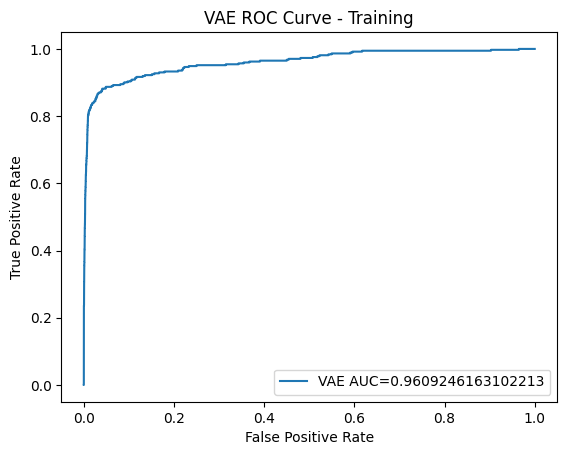

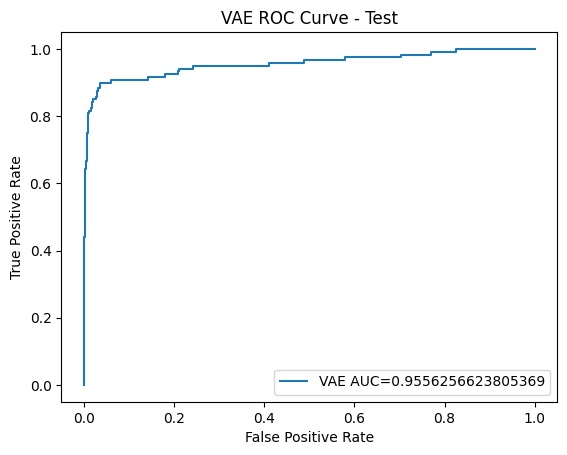

Precision@100: 0.38


In [ ]:
############################GELU变分
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.5))

    def forward(self, input):
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data
x_log_prob = reconstruction_log_prob(x)
fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 9106.3824640625, Validation Loss: 4612.449804220989
Epoch 20/1000, Training Loss: 3643.978698828125, Validation Loss: 3582.4010390749404
Epoch 40/1000, Training Loss: 3520.31935, Validation Loss: 3454.5614293578324
Epoch 60/1000, Training Loss: 3453.990006640625, Validation Loss: 3396.60952039585
Epoch 80/1000, Training Loss: 3420.387666015625, Validation Loss: 3367.8500541152466
Epoch 100/1000, Training Loss: 3383.6575421875, Validation Loss: 3342.4120238480295
Epoch 120/1000, Training Loss: 3351.13507734375, Validation Loss: 3305.448151217904
Epoch 140/1000, Training Loss: 3338.346554296875, Validation Loss: 3285.8755582578624
Epoch 160/1000, Training Loss: 3330.44743828125, Validation Loss: 3282.9197344931827
Epoch 180/1000, Training Loss: 3322.822917578125, Validation Loss: 3276.5321775788716
Epoch 200/1000, Training Loss: 3318.002935546875, Validation Loss: 3274.6197253184714
Epoch 220/1000, Training Loss: 3319.062928515625, Validation Loss: 3268.93392

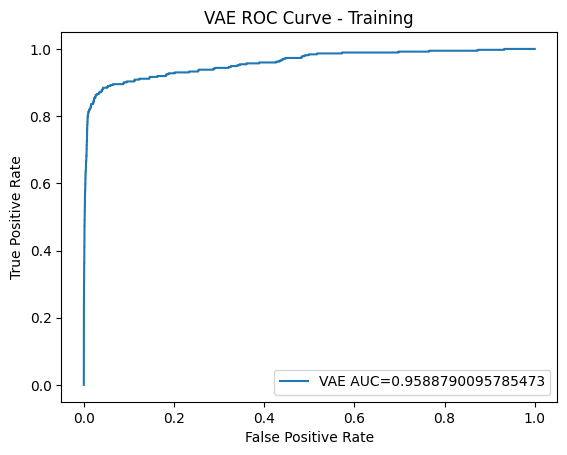

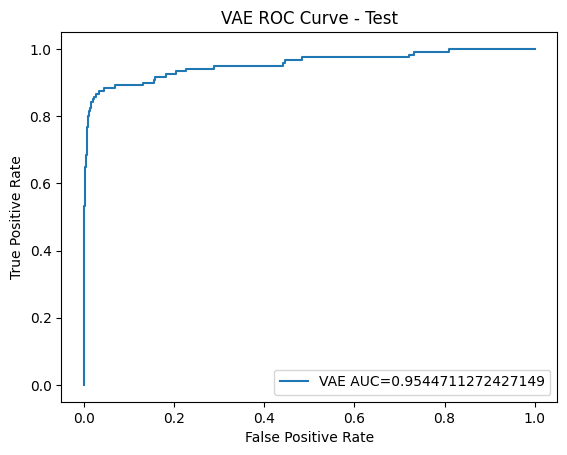

Precision@100: 0.44


In [19]:
############################GELU变分
class RayLU(nn.Module):
    def __init__(self):
        super(RayLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(4.0))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = torch.where(input >= 0, input, input * torch.exp(-input**2 / (2 * self.sigma**2)))
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            RayLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            RayLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            RayLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            RayLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            RayLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            RayLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data
x_log_prob = reconstruction_log_prob(x)
fpr, tpr, _ = roc_curve(y.numpy(), -x_log_prob.numpy())
auc = roc_auc_score(y.numpy(), -x_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 10191.8456171875, Validation Loss: 4919.3648362858285
Epoch 20/1000, Training Loss: 4135.15693046875, Validation Loss: 4090.779577558967
Epoch 40/1000, Training Loss: 3551.90839609375, Validation Loss: 3567.3433383042643
Epoch 60/1000, Training Loss: 3490.302070703125, Validation Loss: 3500.6698005822054
Epoch 80/1000, Training Loss: 3454.9837765625, Validation Loss: 3466.221409888784
Epoch 100/1000, Training Loss: 3429.15373203125, Validation Loss: 3440.664488579817
Epoch 120/1000, Training Loss: 3409.50918203125, Validation Loss: 3429.984093149756
Epoch 140/1000, Training Loss: 3343.433763671875, Validation Loss: 3395.956749788515
Epoch 160/1000, Training Loss: 3307.3274328125, Validation Loss: 3367.327674817128
Epoch 180/1000, Training Loss: 3293.3514546875, Validation Loss: 3352.0912145140824
Epoch 200/1000, Training Loss: 3285.036959765625, Validation Loss: 3352.383221474423
Epoch 220/1000, Training Loss: 3275.843513671875, Validation Loss: 3346.170754

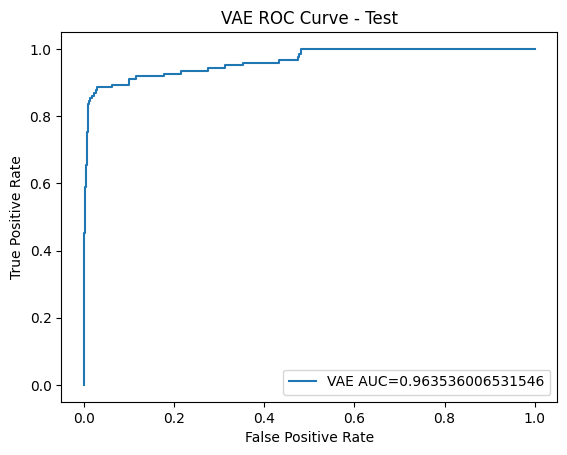

Precision@100: 0.46


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.0))

    def forward(self, input):
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 12161.109112890625, Validation Loss: 4889.36978518735
Epoch 20/1000, Training Loss: 4130.442128515625, Validation Loss: 3914.455284944765
Epoch 40/1000, Training Loss: 3584.514935546875, Validation Loss: 3449.6396923672623
Epoch 60/1000, Training Loss: 3406.10326484375, Validation Loss: 3342.902724733778
Epoch 80/1000, Training Loss: 3334.0429015625, Validation Loss: 3279.446712421004
Epoch 100/1000, Training Loss: 3307.760231640625, Validation Loss: 3244.4397023194915
Epoch 120/1000, Training Loss: 3292.97969453125, Validation Loss: 3238.239265976438
Epoch 140/1000, Training Loss: 3285.211472265625, Validation Loss: 3227.046682953075
Epoch 160/1000, Training Loss: 3280.425209375, Validation Loss: 3231.189552258534
Epoch 180/1000, Training Loss: 3281.035908203125, Validation Loss: 3215.0699486216163
Epoch 200/1000, Training Loss: 3276.02094296875, Validation Loss: 3210.519211690137
Epoch 220/1000, Training Loss: 3275.676319140625, Validation Loss: 3218.2573

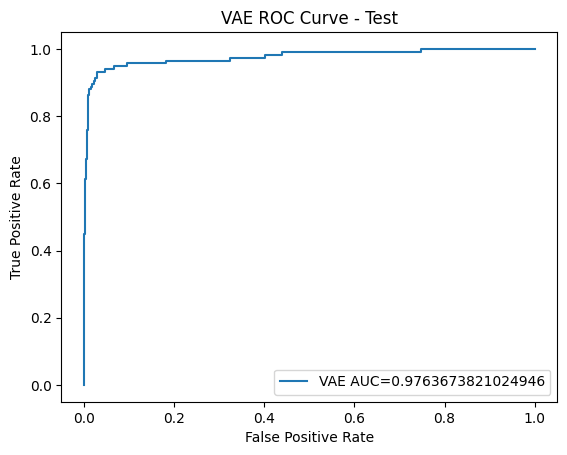

Precision@100: 0.4


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.0))

    def forward(self, input):
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11739.82294140625, Validation Loss: 4804.563042707504
Epoch 20/1000, Training Loss: 3546.501163671875, Validation Loss: 3513.1249961124104
Epoch 40/1000, Training Loss: 3452.969983984375, Validation Loss: 3417.410671355618
Epoch 60/1000, Training Loss: 3390.331509375, Validation Loss: 3355.730686066257
Epoch 80/1000, Training Loss: 3284.171053515625, Validation Loss: 3264.014675650627
Epoch 100/1000, Training Loss: 3247.887242578125, Validation Loss: 3225.6985442532095
Epoch 120/1000, Training Loss: 3231.704774609375, Validation Loss: 3208.0623413863455
Epoch 140/1000, Training Loss: 3221.693635546875, Validation Loss: 3198.4542749489947
Epoch 160/1000, Training Loss: 3213.847859765625, Validation Loss: 3218.014920180011
Epoch 180/1000, Training Loss: 3197.711624609375, Validation Loss: 3178.1205728129976
Epoch 200/1000, Training Loss: 3171.656237890625, Validation Loss: 3147.1117021111168
Epoch 220/1000, Training Loss: 3154.392574609375, Validation Loss: 3

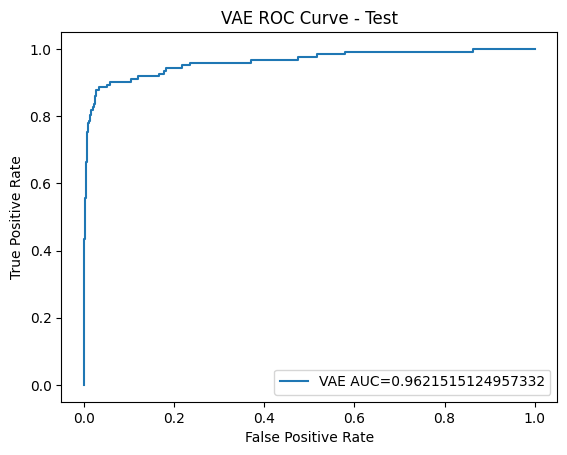

Precision@100: 0.42


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.0))

    def forward(self, input):
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11050.42883125, Validation Loss: 4681.757614232932
Epoch 20/1000, Training Loss: 3655.718446875, Validation Loss: 3535.4501642117834
Epoch 40/1000, Training Loss: 3572.399304296875, Validation Loss: 3457.1151776161923
Epoch 60/1000, Training Loss: 3486.397994921875, Validation Loss: 3377.5658036736168
Epoch 80/1000, Training Loss: 3440.80890234375, Validation Loss: 3333.511166712281
Epoch 100/1000, Training Loss: 3424.28474609375, Validation Loss: 3321.812779906449
Epoch 120/1000, Training Loss: 3415.8080265625, Validation Loss: 3307.854657021298
Epoch 140/1000, Training Loss: 3389.41136953125, Validation Loss: 3276.6382605680233
Epoch 160/1000, Training Loss: 3277.79494765625, Validation Loss: 3181.7585410342854
Epoch 180/1000, Training Loss: 3256.01751875, Validation Loss: 3174.7525891346536
Epoch 200/1000, Training Loss: 3242.10664765625, Validation Loss: 3155.6956398350417
Epoch 220/1000, Training Loss: 3235.400989453125, Validation Loss: 3158.579868195

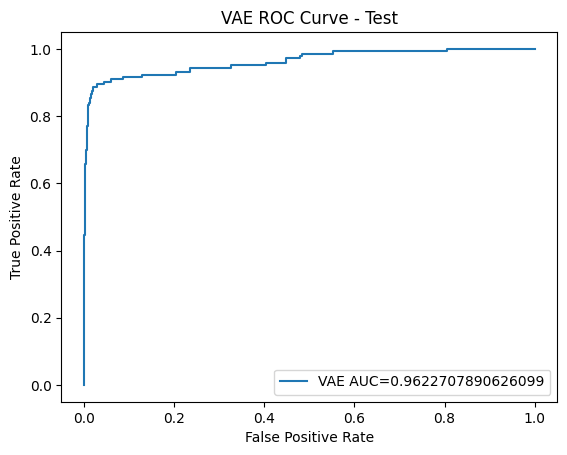

Precision@100: 0.51


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.5))

    def forward(self, input):
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            GELU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 10801.3395, Validation Loss: 4837.288922158016
Epoch 20/1000, Training Loss: 3641.551209765625, Validation Loss: 3588.5891509815388
Epoch 40/1000, Training Loss: 3536.80657109375, Validation Loss: 3476.1664273207357
Epoch 60/1000, Training Loss: 3483.227974609375, Validation Loss: 3430.4876203597732
Epoch 80/1000, Training Loss: 3446.913109765625, Validation Loss: 3389.0852346238057
Epoch 100/1000, Training Loss: 3430.891548046875, Validation Loss: 3371.491391321656
Epoch 120/1000, Training Loss: 3414.93569375, Validation Loss: 3354.24650738953
Epoch 140/1000, Training Loss: 3388.6524421875, Validation Loss: 3340.169688619626
Epoch 160/1000, Training Loss: 3354.724546484375, Validation Loss: 3327.9577329599174
Epoch 180/1000, Training Loss: 3323.509419921875, Validation Loss: 3297.611828069019
Epoch 200/1000, Training Loss: 3306.9469796875, Validation Loss: 3285.5266809159784
Epoch 220/1000, Training Loss: 3291.84615859375, Validation Loss: 3271.66018501816

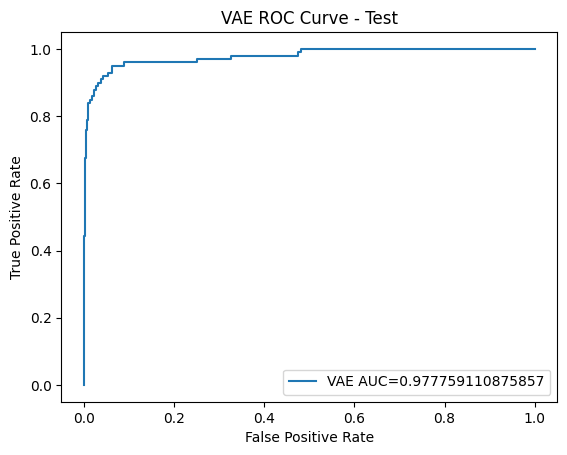

Precision@100: 0.37


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.5))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.sigmoid(input / self.sigma)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11399.650246484374, Validation Loss: 5011.902408283987
Epoch 20/1000, Training Loss: 4375.460290625, Validation Loss: 4327.425866776971
Epoch 40/1000, Training Loss: 3603.147845703125, Validation Loss: 3550.381357375224
Epoch 60/1000, Training Loss: 3530.23217421875, Validation Loss: 3482.841835362137
Epoch 80/1000, Training Loss: 3368.404450390625, Validation Loss: 3311.4565565753137
Epoch 100/1000, Training Loss: 3306.83941953125, Validation Loss: 3259.361300134355
Epoch 120/1000, Training Loss: 3293.68968359375, Validation Loss: 3242.418827518536
Epoch 140/1000, Training Loss: 3281.3921078125, Validation Loss: 3226.002968952155
Epoch 160/1000, Training Loss: 3288.716316015625, Validation Loss: 3238.797238100866
Epoch 180/1000, Training Loss: 3268.351906640625, Validation Loss: 3210.173285417496
Epoch 200/1000, Training Loss: 3264.2902671875, Validation Loss: 3213.565520657096
Epoch 220/1000, Training Loss: 3258.744764453125, Validation Loss: 3205.6232389

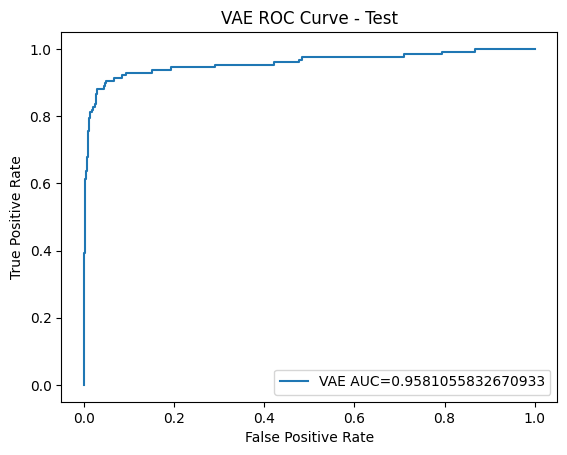

Precision@100: 0.4


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.5))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.sigmoid(input / self.sigma)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11278.617482421874, Validation Loss: 4983.526833698248
Epoch 20/1000, Training Loss: 4254.263094921875, Validation Loss: 4434.203643604449
Epoch 40/1000, Training Loss: 3625.38687265625, Validation Loss: 3712.582105114202
Epoch 60/1000, Training Loss: 3526.982883984375, Validation Loss: 3616.934300902543
Epoch 80/1000, Training Loss: 3466.9412609375, Validation Loss: 3548.800527001642
Epoch 100/1000, Training Loss: 3417.04523203125, Validation Loss: 5645740.1995223705
Epoch 120/1000, Training Loss: 3367.57061328125, Validation Loss: 3577.053803462132
Epoch 140/1000, Training Loss: 3329.338966796875, Validation Loss: 3384.097838189192
Epoch 160/1000, Training Loss: 3310.774864453125, Validation Loss: 3373.1022125049763
Epoch 180/1000, Training Loss: 3302.03032890625, Validation Loss: 3350.383807334171
Epoch 200/1000, Training Loss: 3293.262430078125, Validation Loss: 3348.9714856967803
Epoch 220/1000, Training Loss: 3283.74187578125, Validation Loss: 3337.11

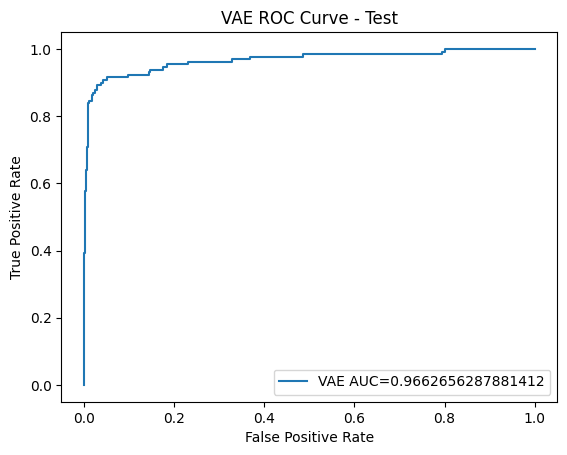

Precision@100: 0.38


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.5))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.sigmoid(input / self.sigma)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 10094.637334765624, Validation Loss: 4726.099142864252
Epoch 20/1000, Training Loss: 4284.363646484375, Validation Loss: 4263.886160492138
Epoch 40/1000, Training Loss: 3582.095501953125, Validation Loss: 3580.968982089097
Epoch 60/1000, Training Loss: 3434.365695703125, Validation Loss: 3412.8419745378433
Epoch 80/1000, Training Loss: 3357.72202734375, Validation Loss: 3341.9552009728304
Epoch 100/1000, Training Loss: 3315.982358984375, Validation Loss: 3294.7063932965516
Epoch 120/1000, Training Loss: 3283.2775078125, Validation Loss: 3274.5122777853803
Epoch 140/1000, Training Loss: 3267.27259609375, Validation Loss: 3252.390279393287
Epoch 160/1000, Training Loss: 3250.802341015625, Validation Loss: 3236.2937587082006
Epoch 180/1000, Training Loss: 3229.75460859375, Validation Loss: 3218.826006652443
Epoch 200/1000, Training Loss: 3211.762823828125, Validation Loss: 3185.970087330812
Epoch 220/1000, Training Loss: 3206.32770546875, Validation Loss: 3176

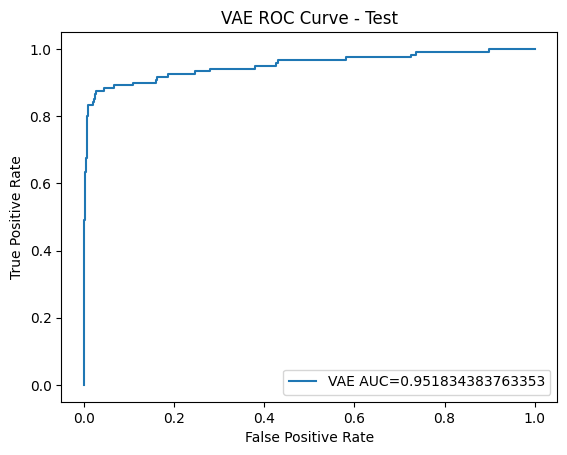

Precision@100: 0.47


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.7))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.sigmoid(input / self.sigma)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 10341.17620390625, Validation Loss: 5155.8305920643415
Epoch 20/1000, Training Loss: 3668.8002421875, Validation Loss: 3646.9033805701383
Epoch 40/1000, Training Loss: 3456.02944140625, Validation Loss: 3469.6070797671177
Epoch 60/1000, Training Loss: 3340.678098828125, Validation Loss: 3360.614875550483
Epoch 80/1000, Training Loss: 3293.476002734375, Validation Loss: 3318.2586650483927
Epoch 100/1000, Training Loss: 3268.83906171875, Validation Loss: 3287.844005414635
Epoch 120/1000, Training Loss: 3256.509784765625, Validation Loss: 3279.6435204767117
Epoch 140/1000, Training Loss: 3244.934312109375, Validation Loss: 3273.9415905217456
Epoch 160/1000, Training Loss: 3242.634036328125, Validation Loss: 3267.0067123121516
Epoch 180/1000, Training Loss: 3236.72466328125, Validation Loss: 3263.7982364338673
Epoch 200/1000, Training Loss: 3233.80946171875, Validation Loss: 3259.3835946830213
Epoch 220/1000, Training Loss: 3231.2231625, Validation Loss: 3254.2

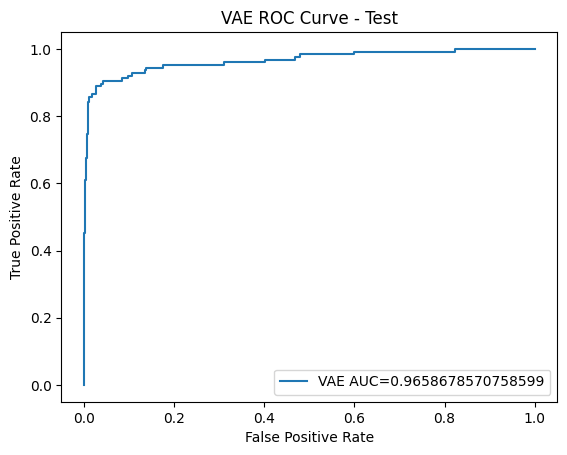

Precision@100: 0.49


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.5))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.sigmoid(input / self.sigma)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11315.24605859375, Validation Loss: 5065.782572557971
Epoch 20/1000, Training Loss: 4316.715651953125, Validation Loss: 4431.3838784770605
Epoch 40/1000, Training Loss: 4307.329176171875, Validation Loss: 4420.669047944864
Epoch 60/1000, Training Loss: 3595.846884375, Validation Loss: 3656.1194403581558
Epoch 80/1000, Training Loss: 3525.007377734375, Validation Loss: 3572.529079947502
Epoch 100/1000, Training Loss: 3422.522549609375, Validation Loss: 3455.039938762689
Epoch 120/1000, Training Loss: 3333.75079609375, Validation Loss: 3376.0881211590613
Epoch 140/1000, Training Loss: 3306.298906640625, Validation Loss: 3339.271466880847
Epoch 160/1000, Training Loss: 3288.936594921875, Validation Loss: 3326.9085790549116
Epoch 180/1000, Training Loss: 3277.8506265625, Validation Loss: 3308.6016970105993
Epoch 200/1000, Training Loss: 3269.64192109375, Validation Loss: 3306.8243423753484
Epoch 220/1000, Training Loss: 3262.090801953125, Validation Loss: 3294.

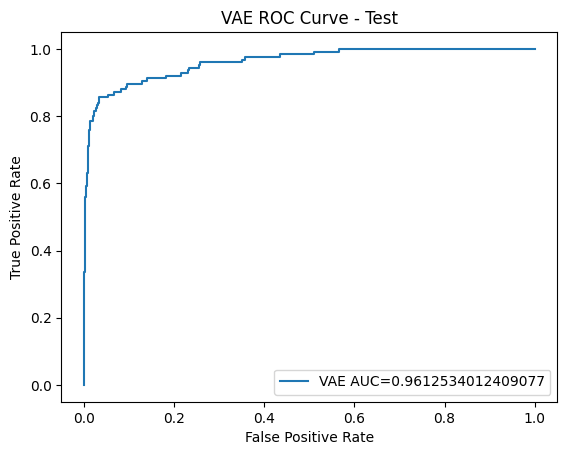

Precision@100: 0.36


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.8))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.sigmoid(input / self.sigma)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 11478.48760390625, Validation Loss: 4588.684459904956
Epoch 20/1000, Training Loss: 3670.3889875, Validation Loss: 3479.045330849423
Epoch 40/1000, Training Loss: 3551.3099703125, Validation Loss: 3346.7723038788813
Epoch 60/1000, Training Loss: 3478.72839453125, Validation Loss: 3275.713144873358
Epoch 80/1000, Training Loss: 3428.358084375, Validation Loss: 3241.989424201334
Epoch 100/1000, Training Loss: 3360.058328515625, Validation Loss: 3220.5709943832107
Epoch 120/1000, Training Loss: 3269.23745703125, Validation Loss: 3176.9519871025327
Epoch 140/1000, Training Loss: 3244.29000859375, Validation Loss: 3164.282333859972
Epoch 160/1000, Training Loss: 3229.128783203125, Validation Loss: 3156.6784162582107
Epoch 180/1000, Training Loss: 3222.15780703125, Validation Loss: 3155.0099491192277
Epoch 200/1000, Training Loss: 3203.49073984375, Validation Loss: 3130.6763262900577
Epoch 220/1000, Training Loss: 3194.250132421875, Validation Loss: 3127.25308985

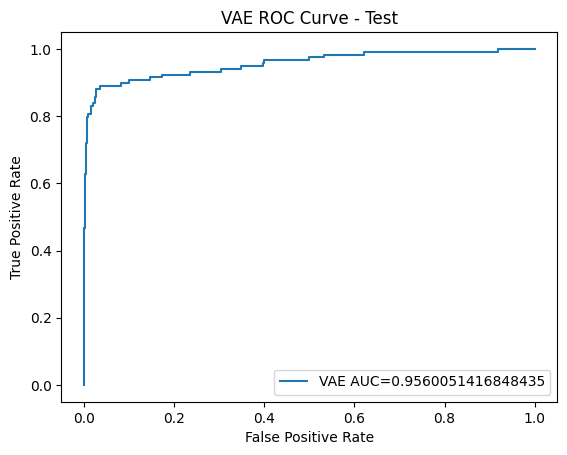

Precision@100: 0.42


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.76))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.sigmoid(input / self.sigma)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

In [7]:
# GELU
# 0.9635,0.9763,0.9621,0.9622,0.9556
# 0.46,0.40,0.42,0.51,0.38
# SiLU
# 0.9560, 0.9581,0.9518,0.9658
# 0.42,0.4,0.38,0.47,0.49

Epoch 0/1000, Training Loss: 9551.4747015625, Validation Loss: 4796.689146005424
Epoch 20/1000, Training Loss: 3606.849506640625, Validation Loss: 3535.9494974901722
Epoch 40/1000, Training Loss: 3480.971530859375, Validation Loss: 3418.0511766178593
Epoch 60/1000, Training Loss: 3441.464765625, Validation Loss: 3383.011155438271
Epoch 80/1000, Training Loss: 3421.04413515625, Validation Loss: 3360.102556167894
Epoch 100/1000, Training Loss: 3385.53856875, Validation Loss: 3327.39119530939
Epoch 120/1000, Training Loss: 3348.0264875, Validation Loss: 3295.997278298542
Epoch 140/1000, Training Loss: 3328.292190625, Validation Loss: 3280.355604815635
Epoch 160/1000, Training Loss: 3312.148631640625, Validation Loss: 3272.014568353155
Epoch 180/1000, Training Loss: 3303.644362109375, Validation Loss: 3271.880192653389
Epoch 200/1000, Training Loss: 3286.27995390625, Validation Loss: 3264.3302180782243
Epoch 220/1000, Training Loss: 3278.527817578125, Validation Loss: 3248.8098093992585
Ep

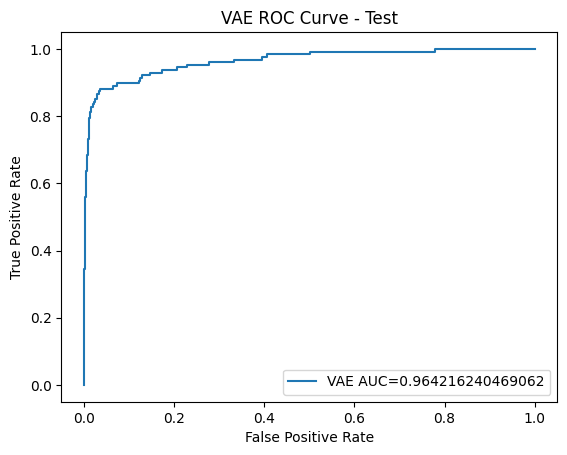

Precision@100: 0.34


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.2))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = input * torch.tanh(softplus)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 10733.147146484374, Validation Loss: 5073.606007569914
Epoch 20/1000, Training Loss: 4362.223888671875, Validation Loss: 4511.62248006444
Epoch 40/1000, Training Loss: 3610.558928515625, Validation Loss: 3762.666785367735
Epoch 60/1000, Training Loss: 3492.932236328125, Validation Loss: 3659.3761274009753
Epoch 80/1000, Training Loss: 3429.36236171875, Validation Loss: 3604.032987752538
Epoch 100/1000, Training Loss: 3365.358089453125, Validation Loss: 3546.554032829916
Epoch 120/1000, Training Loss: 3310.0413109375, Validation Loss: 3450.600114761644
Epoch 140/1000, Training Loss: 3253.05102265625, Validation Loss: 3356.807962405454
Epoch 160/1000, Training Loss: 3214.475837109375, Validation Loss: 3282.2248496280354
Epoch 180/1000, Training Loss: 3202.9875125, Validation Loss: 3289.8093829306827
Epoch 200/1000, Training Loss: 3197.662124609375, Validation Loss: 3272.755204704916
Epoch 220/1000, Training Loss: 3188.994278515625, Validation Loss: 3253.75714

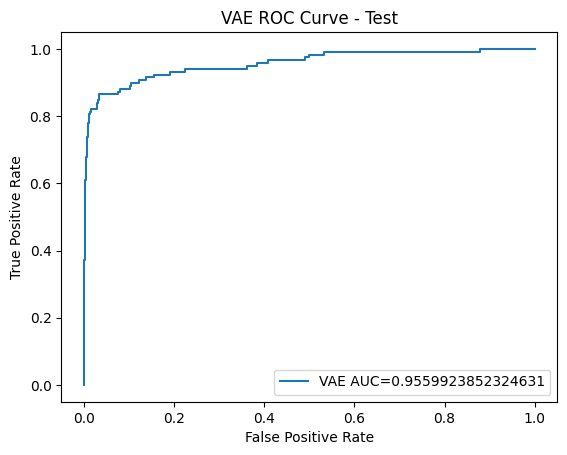

Precision@100: 0.38


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.2))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = input * torch.tanh(softplus)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 10385.13866875, Validation Loss: 4989.841263497711
Epoch 20/1000, Training Loss: 3898.41895546875, Validation Loss: 3953.876321780454
Epoch 40/1000, Training Loss: 3548.54749609375, Validation Loss: 3644.353078271173
Epoch 60/1000, Training Loss: 3434.11069296875, Validation Loss: 3528.6785235556827
Epoch 80/1000, Training Loss: 3395.57587421875, Validation Loss: 3487.7744599360567
Epoch 100/1000, Training Loss: 3376.825551953125, Validation Loss: 3469.278024466934
Epoch 120/1000, Training Loss: 3367.565527734375, Validation Loss: 3460.310120406424
Epoch 140/1000, Training Loss: 3358.627908203125, Validation Loss: 3454.9260596014133
Epoch 160/1000, Training Loss: 3350.15496484375, Validation Loss: 3443.22969706347
Epoch 180/1000, Training Loss: 3347.768900390625, Validation Loss: 3442.295662849572
Epoch 200/1000, Training Loss: 3344.88153828125, Validation Loss: 3438.6486248818173
Epoch 220/1000, Training Loss: 4375.7493046875, Validation Loss: 4417.3238805

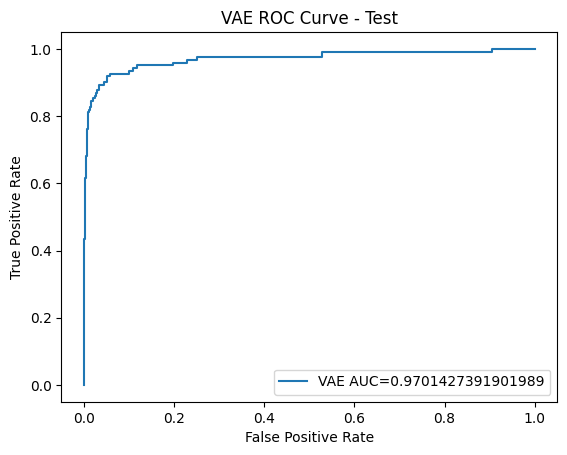

Precision@100: 0.42


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.2))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = input * torch.tanh(softplus)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 10409.8379, Validation Loss: 4686.377808394705
Epoch 20/1000, Training Loss: 3600.159440234375, Validation Loss: 3538.75115539162
Epoch 40/1000, Training Loss: 3498.581294140625, Validation Loss: 3454.042496019108
Epoch 60/1000, Training Loss: 3382.586596875, Validation Loss: 3341.1092925831013
Epoch 80/1000, Training Loss: 3321.04199140625, Validation Loss: 3288.3700946394806
Epoch 100/1000, Training Loss: 3296.034808203125, Validation Loss: 3263.3131352321357
Epoch 120/1000, Training Loss: 3284.8672671875, Validation Loss: 3251.4692460564293
Epoch 140/1000, Training Loss: 3273.703896484375, Validation Loss: 3234.5283008745523
Epoch 160/1000, Training Loss: 3264.0751109375, Validation Loss: 3226.2585013808716
Epoch 180/1000, Training Loss: 3260.268578515625, Validation Loss: 3215.3015074517316
Epoch 200/1000, Training Loss: 3256.99946015625, Validation Loss: 3223.5421951196754
Epoch 220/1000, Training Loss: 3250.546058984375, Validation Loss: 3210.74268822

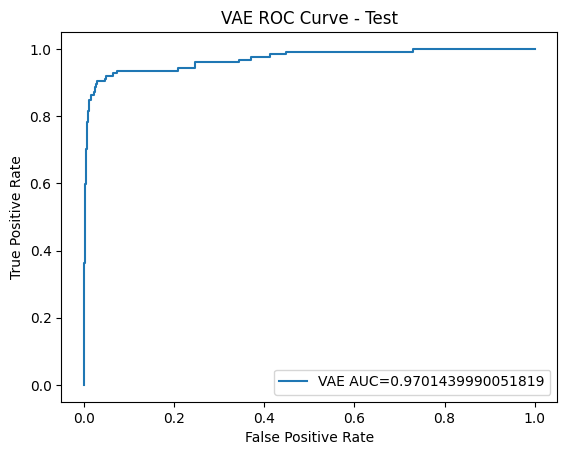

Precision@100: 0.37


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.2))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = input * torch.tanh(softplus)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 9910.04389140625, Validation Loss: 4816.703742349224
Epoch 20/1000, Training Loss: 3583.685778515625, Validation Loss: 3598.260606510624
Epoch 40/1000, Training Loss: 3497.9480671875, Validation Loss: 3508.1157708623605
Epoch 60/1000, Training Loss: 3436.234913671875, Validation Loss: 3452.7846376455514
Epoch 80/1000, Training Loss: 3386.615205859375, Validation Loss: 3395.183464682026
Epoch 100/1000, Training Loss: 3347.174065234375, Validation Loss: 3356.835864024557
Epoch 120/1000, Training Loss: 3331.547441015625, Validation Loss: 3342.311136233579
Epoch 140/1000, Training Loss: 3272.216028515625, Validation Loss: 3281.8229929930085
Epoch 160/1000, Training Loss: 3253.443575390625, Validation Loss: 3261.036298423816
Epoch 180/1000, Training Loss: 3239.37350390625, Validation Loss: 3240.1968033906
Epoch 200/1000, Training Loss: 3234.687126171875, Validation Loss: 3230.778344804314
Epoch 220/1000, Training Loss: 3228.086490234375, Validation Loss: 3232.66

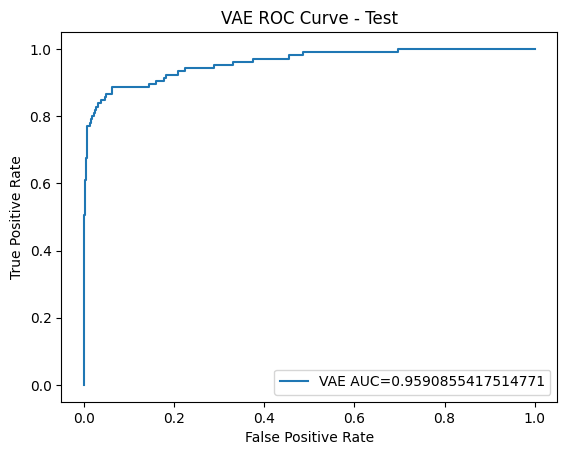

Precision@100: 0.4


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(3.2))

    def forward(self, input):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = input * torch.tanh(softplus)
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Mish(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 9672.781995703124, Validation Loss: 4627.764074629279
Epoch 20/1000, Training Loss: 3659.18605, Validation Loss: 3651.596778821034
Epoch 40/1000, Training Loss: 3634.02103125, Validation Loss: 3630.7841295375947
Epoch 60/1000, Training Loss: 3603.943090234375, Validation Loss: 3608.3132192040703
Epoch 80/1000, Training Loss: 3492.106198046875, Validation Loss: 3494.7743674114254
Epoch 100/1000, Training Loss: 3389.317661328125, Validation Loss: 3388.075094235171
Epoch 120/1000, Training Loss: 3356.918346484375, Validation Loss: 3352.5812685049264
Epoch 140/1000, Training Loss: 3337.03508828125, Validation Loss: 3339.819011323771
Epoch 160/1000, Training Loss: 3317.0136890625, Validation Loss: 3314.79743792297
Epoch 180/1000, Training Loss: 3306.96409765625, Validation Loss: 3309.026259890028
Epoch 200/1000, Training Loss: 3295.878183984375, Validation Loss: 3299.7452785224673
Epoch 220/1000, Training Loss: 3282.950800390625, Validation Loss: 3282.3412673853

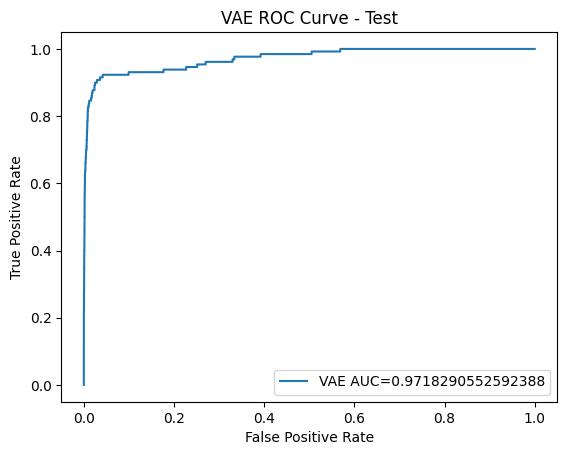

Precision@100: 0.45


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Gumbel(nn.Module):
    def __init__(self):
        super(Gumbel, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(2.0))

    def forward(self, x):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        #softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = torch.where(x >= 0, x, x * torch.exp(-x**2 / (2 * self.sigma**2)))
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 8738.972925, Validation Loss: 4568.431918976413
Epoch 20/1000, Training Loss: 3647.43362265625, Validation Loss: 3620.7613634243135
Epoch 40/1000, Training Loss: 3483.232566796875, Validation Loss: 3481.632398471711
Epoch 60/1000, Training Loss: 3438.587293359375, Validation Loss: 3417.033254441182
Epoch 80/1000, Training Loss: 3310.0725140625, Validation Loss: 3289.931136015874
Epoch 100/1000, Training Loss: 3284.01963828125, Validation Loss: 3253.369981510624
Epoch 120/1000, Training Loss: 3272.88063984375, Validation Loss: 3250.0542831906846
Epoch 140/1000, Training Loss: 3260.590671484375, Validation Loss: 3230.136060969845
Epoch 160/1000, Training Loss: 3251.202120703125, Validation Loss: 3231.589781159808
Epoch 180/1000, Training Loss: 3247.225606640625, Validation Loss: 3228.988039441929
Epoch 200/1000, Training Loss: 3242.128562109375, Validation Loss: 3222.953685590416
Epoch 220/1000, Training Loss: 3236.572194140625, Validation Loss: 3218.79629652

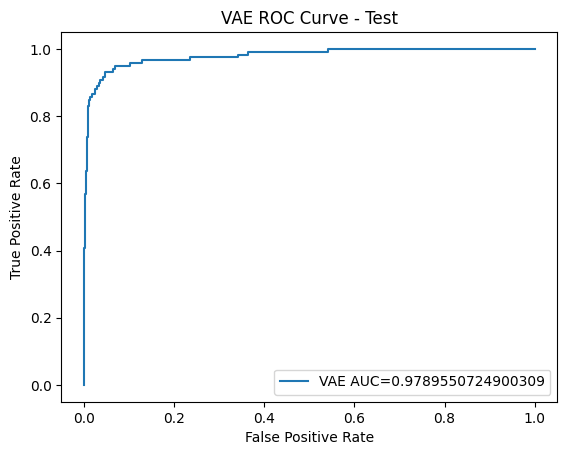

Precision@100: 0.36


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Gumbel(nn.Module):
    def __init__(self):
        super(Gumbel, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(2.0))

    def forward(self, x):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        #softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = torch.where(x >= 0, x, x * torch.exp(-x**2 / (2 * self.sigma**2)))
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 9208.01721015625, Validation Loss: 4450.074083850642
Epoch 20/1000, Training Loss: 3613.14355625, Validation Loss: 3501.9747131736417
Epoch 40/1000, Training Loss: 3589.43030859375, Validation Loss: 3475.4015273561904
Epoch 60/1000, Training Loss: 3516.4296734375, Validation Loss: 3403.4588537519903
Epoch 80/1000, Training Loss: 3457.610080078125, Validation Loss: 3342.6217865184612
Epoch 100/1000, Training Loss: 3434.638905859375, Validation Loss: 3321.9454718911725
Epoch 120/1000, Training Loss: 3426.847820703125, Validation Loss: 3314.127917247213
Epoch 140/1000, Training Loss: 3420.1626046875, Validation Loss: 3304.611944307947
Epoch 160/1000, Training Loss: 3409.54185390625, Validation Loss: 3299.4313198988607
Epoch 180/1000, Training Loss: 3401.7151140625, Validation Loss: 3294.67887499378
Epoch 200/1000, Training Loss: 3334.620394140625, Validation Loss: 3244.5485245042546
Epoch 220/1000, Training Loss: 3300.975864453125, Validation Loss: 3214.121196

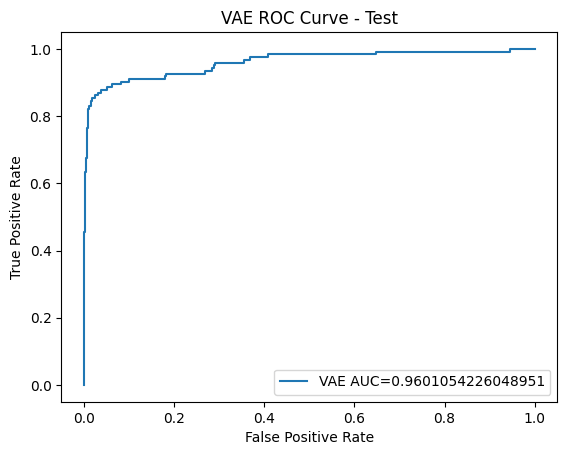

Precision@100: 0.46


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Gumbel(nn.Module):
    def __init__(self):
        super(Gumbel, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(2.0))

    def forward(self, x):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        #softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = torch.where(x >= 0, x, x * torch.exp(-x**2 / (2 * self.sigma**2)))
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 10308.566656640625, Validation Loss: 4719.291814135898
Epoch 20/1000, Training Loss: 3535.66866953125, Validation Loss: 3569.1336662146696
Epoch 40/1000, Training Loss: 3475.657493359375, Validation Loss: 3522.6591388678094
Epoch 60/1000, Training Loss: 3449.81701328125, Validation Loss: 3495.6571962393014
Epoch 80/1000, Training Loss: 3438.6536359375, Validation Loss: 3477.3815505884254
Epoch 100/1000, Training Loss: 3400.42889453125, Validation Loss: 3443.684553595865
Epoch 120/1000, Training Loss: 3359.26586328125, Validation Loss: 3395.419598816307
Epoch 140/1000, Training Loss: 3334.1771984375, Validation Loss: 3370.9198114674564
Epoch 160/1000, Training Loss: 3314.64696015625, Validation Loss: 3363.082762116839
Epoch 180/1000, Training Loss: 3300.286416796875, Validation Loss: 3339.345794094596
Epoch 200/1000, Training Loss: 3291.333430859375, Validation Loss: 3329.101057113356
Epoch 220/1000, Training Loss: 3284.4505234375, Validation Loss: 3314.6326

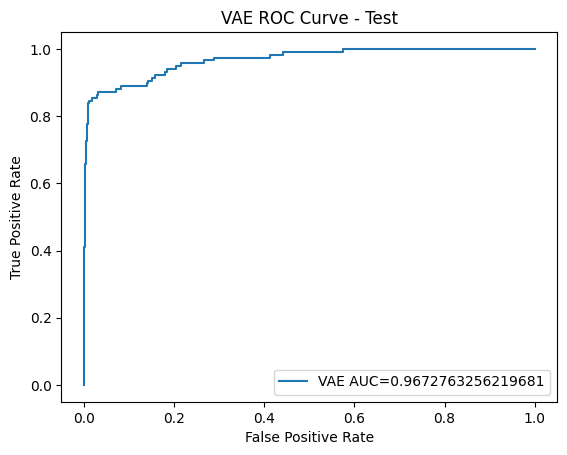

Precision@100: 0.43


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Gumbel(nn.Module):
    def __init__(self):
        super(Gumbel, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(2.0))

    def forward(self, x):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        #softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = torch.where(x >= 0, x, x * torch.exp(-x**2 / (2 * self.sigma**2)))
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

Epoch 0/1000, Training Loss: 9570.970840234375, Validation Loss: 4803.593109325238
Epoch 20/1000, Training Loss: 3525.339563671875, Validation Loss: 3564.036081107559
Epoch 40/1000, Training Loss: 3422.608060546875, Validation Loss: 3463.4986735544385
Epoch 60/1000, Training Loss: 3399.277903515625, Validation Loss: 3440.6826677261643
Epoch 80/1000, Training Loss: 3384.81479140625, Validation Loss: 3420.9153691188544
Epoch 100/1000, Training Loss: 3374.564425, Validation Loss: 3413.5321402580116
Epoch 120/1000, Training Loss: 3305.3952765625, Validation Loss: 3341.4113629578023
Epoch 140/1000, Training Loss: 3280.384248046875, Validation Loss: 3313.7719668248656
Epoch 160/1000, Training Loss: 3268.07001640625, Validation Loss: 3293.9445373146395
Epoch 180/1000, Training Loss: 3255.293236328125, Validation Loss: 3287.4039213338474
Epoch 200/1000, Training Loss: 3239.089990625, Validation Loss: 3269.584653040406
Epoch 220/1000, Training Loss: 3233.723935546875, Validation Loss: 3265.4084

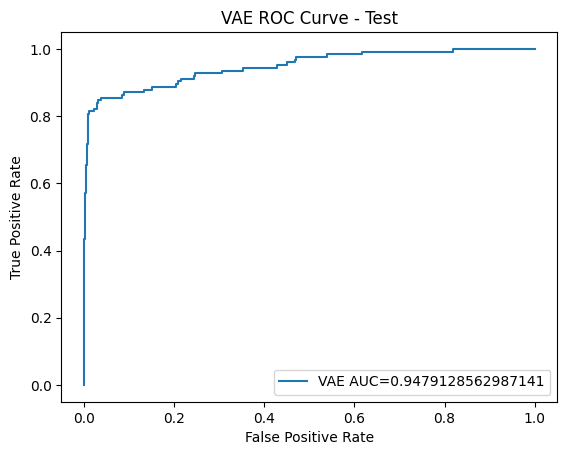

Precision@100: 0.42


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

# Data preprocessing
data["Time"] = data["Time"] / 3600 % 24
data["Amount"] = np.log(data["Amount"] + 1)
data_test["Time"] = data_test["Time"] / 3600 % 24
data_test["Amount"] = np.log(data_test["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 将 Pandas 数据转化为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000
# Preparing the data for PyTorch
# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 从正常样本中随机抽取 100,000 个样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 将正常样本分割为训练集和验证集（80%/20%）
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader 用于训练和验证
train_dataset = TensorDataset(x_norm_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_norm_val_sample)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ROC curve
def reconstruction_log_prob(eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

from sklearn.metrics import precision_score

# 计算precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    # 确保模型处于评估模式
    model.eval()
    
    # 计算重建误差（或对数概率）
    reconstruction_errors = reconstruction_log_prob(test_data)  # 重建误差是一个负值，较小的值表示更好的重构
    
    # 计算误差的排序索引
    sorted_indices = np.argsort(reconstruction_errors)
    
    # 选择前k个最相关的样本
    top_k_indices = sorted_indices[:k]
    
    # 获取前k个预测标签
    top_k_labels = test_labels[top_k_indices]
    
    # 计算precision@k
    # 这里假设标签是二分类的，相关标签为1，非相关标签为0
    precision_at_k = np.sum(top_k_labels == 1) / k  # 计算相关标签的比例
    return precision_at_k

class Gumbel(nn.Module):
    def __init__(self):
        super(Gumbel, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(2.0))

    def forward(self, x):
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input / self.sigma)
        #softplus = torch.nn.functional.softplus(input / self.sigma)
        temp = torch.where(x >= 0, x, x * torch.exp(-x**2 / (2 * self.sigma**2)))
        return temp
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Gumbel(),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel()
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        x = self.fc_layers(z)
        return self.output_layer(x)

# VAE Model combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mean, log_var

# Initialize model, optimizer, and loss function
model = VAE(input_dim=original_dim, intermediary_dims1=intermediary_dims1, intermediary_dims2=intermediary_dims2,
            intermediary_dims3=intermediary_dims3, latent_dim=latent_dim, output_dim=original_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
test_y = data_test["Class"].values
# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        optimizer.zero_grad()
        data = data[0]  # data is a tuple, we need to extract the tensor
        reconstructed_data, mean, log_var = model(data)
        loss = vae_loss(data, reconstructed_data, mean, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            data = data[0]
            reconstructed_data, mean, log_var = model(data)
            loss = vae_loss(data, reconstructed_data, mean, log_var)
            val_loss += loss.item()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Calculate log-probabilities for the training data

# Calculate log-probabilities for the test data
x_test_log_prob = reconstruction_log_prob(X_test_tensor)
fpr, tpr, _ = roc_curve(test_y, -x_test_log_prob.numpy())
auc = roc_auc_score(test_y, -x_test_log_prob.numpy())

plt.plot(fpr, tpr, label="VAE AUC=" + str(auc))
plt.title('VAE ROC Curve - Test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

# 计算precision@100
precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
print("Precision@100:", precision_at_100)

In [1]:
##汇总

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv(r"D:\Credit Card Fraud Detection\creditcard.csv")  # 修正路径
data, data_test = train_test_split(raw_data, test_size=0.25, random_state=42)

# Data preprocessing
for df in [data, data_test]:
    df["Time"] = df["Time"] / 3600 % 24
    df["Amount"] = np.log(df["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 转换 Pandas DataFrame 为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000

# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 取 100,000 个正常样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 拆分训练集和验证集
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2, random_state=42)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader
train_loader = DataLoader(TensorDataset(x_norm_train_sample), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_norm_val_sample), batch_size=batch_size, shuffle=False)

# 计算重建误差
def reconstruction_log_prob(model, eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

# 计算 precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    model.eval()
    reconstruction_errors = reconstruction_log_prob(model, test_data).numpy()  # 修正
    sorted_indices = np.argsort(reconstruction_errors)  # 由小到大排序
    top_k_indices = sorted_indices[:k]
    top_k_labels = test_labels[top_k_indices]
    precision_at_k = np.sum(top_k_labels == 1) / k
    return precision_at_k

# 自定义 Gumbel 激活函数
class Gumbel(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        return torch.where(input >= 0, input, input * torch.exp(-input**2 / (2 * self.sigma**2)))

# 定义 VAE 结构
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Gumbel(trial.suggest_float("sigma_1", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(trial.suggest_float("sigma_2", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel(trial.suggest_float("sigma_3", 0.1, 4.0))
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        return self.mean(x), self.log_var(x)

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Gumbel(trial.suggest_float("sigma_4", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Gumbel(trial.suggest_float("sigma_5", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Gumbel(trial.suggest_float("sigma_6", 0.1, 4.0))
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        return self.output_layer(self.fc_layers(z))

class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim, trial):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

# Optuna 目标函数
def objective(trial):
    model = VAE(original_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, original_dim, trial)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练循环
    for epoch in range(max_epochs):
        for data in train_loader:
            optimizer.zero_grad()
            reconstructed_data, mean, log_var = model(data[0])
            loss = vae_loss(data[0], reconstructed_data, mean, log_var)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
    
    # 评估模型
    X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
    test_y = data_test["Class"].values
    auc = roc_auc_score(test_y, -reconstruction_log_prob(model, X_test_tensor).numpy())
    precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
    print(f"Trial {trial.number}: AUC = {auc:.4f}, Precision@100 = {precision_at_100:.4f}")

    return auc + precision_at_100

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial parameters:", study.best_trial.params)


[I 2025-04-03 15:57:08,071] A new study created in memory with name: no-name-52403bb1-6351-4c2b-9d51-1096c83a68eb


Epoch 50: Loss = 3315.6121
Epoch 100: Loss = 3200.9146
Epoch 150: Loss = 2990.9209
Epoch 200: Loss = 2632.2441
Epoch 250: Loss = 3798.4893
Epoch 300: Loss = 3149.6360
Epoch 350: Loss = 3228.4229
Epoch 400: Loss = 3136.8154
Epoch 450: Loss = 3110.6282
Epoch 500: Loss = 3262.4736
Epoch 550: Loss = 2619.9685
Epoch 600: Loss = 2758.2500
Epoch 650: Loss = 4108.1777
Epoch 700: Loss = 2803.7468
Epoch 750: Loss = 3220.0449
Epoch 800: Loss = 3082.5488
Epoch 850: Loss = 2828.7773
Epoch 900: Loss = 2779.5564
Epoch 950: Loss = 2796.6799


[I 2025-04-03 16:50:21,369] Trial 0 finished with value: 1.364255201973545 and parameters: {'sigma_1': 3.571432030914694, 'sigma_2': 2.3406066583033738, 'sigma_3': 3.1717331521005323, 'sigma_4': 0.8504833714726394, 'sigma_5': 0.801315885758703, 'sigma_6': 2.176323069196992}. Best is trial 0 with value: 1.364255201973545.


Epoch 1000: Loss = 2769.0352
Trial 0: AUC = 0.9643, Precision@100 = 0.4000
Epoch 50: Loss = 3062.9592
Epoch 100: Loss = 3547.3181
Epoch 150: Loss = 2815.4204
Epoch 200: Loss = 3037.5090
Epoch 250: Loss = 3549.4343
Epoch 300: Loss = 2624.7373
Epoch 350: Loss = 3024.8433
Epoch 400: Loss = 3094.7908
Epoch 450: Loss = 3234.2212
Epoch 500: Loss = 2994.8596
Epoch 550: Loss = 2966.2856
Epoch 600: Loss = 3394.2083
Epoch 650: Loss = 3792.1108
Epoch 700: Loss = 2972.1526
Epoch 750: Loss = 4060.8267
Epoch 800: Loss = 3823.1707
Epoch 850: Loss = 3460.9729
Epoch 900: Loss = 3179.8467
Epoch 950: Loss = 2925.8325


[I 2025-04-03 17:44:09,858] Trial 1 finished with value: 1.3446154633285934 and parameters: {'sigma_1': 1.6002540654789112, 'sigma_2': 2.8806430415686304, 'sigma_3': 0.6419614194435496, 'sigma_4': 3.210451520588285, 'sigma_5': 0.3992760832790464, 'sigma_6': 0.13332639095864032}. Best is trial 0 with value: 1.364255201973545.


Epoch 1000: Loss = 3056.9282
Trial 1: AUC = 0.9646, Precision@100 = 0.3800
Epoch 50: Loss = 3038.2495
Epoch 100: Loss = 3145.1440
Epoch 150: Loss = 3755.9363
Epoch 200: Loss = 3137.3477
Epoch 250: Loss = 3078.9060
Epoch 300: Loss = 2889.5627
Epoch 350: Loss = 2875.6399
Epoch 400: Loss = 5447.2515
Epoch 450: Loss = 2826.5378
Epoch 500: Loss = 3028.9751
Epoch 550: Loss = 3132.5981
Epoch 600: Loss = 2779.8147
Epoch 650: Loss = 2829.8950
Epoch 700: Loss = 2808.8264
Epoch 750: Loss = 3099.1987
Epoch 800: Loss = 2692.3562
Epoch 850: Loss = 2750.6152
Epoch 900: Loss = 2704.4763
Epoch 950: Loss = 2710.5503


[I 2025-04-03 18:38:10,910] Trial 2 finished with value: 1.3265873153893963 and parameters: {'sigma_1': 3.5078254189699587, 'sigma_2': 1.5897404260806935, 'sigma_3': 0.6077873922491167, 'sigma_4': 0.241217376952512, 'sigma_5': 1.6737864695770561, 'sigma_6': 1.0873478704808874}. Best is trial 0 with value: 1.364255201973545.


Epoch 1000: Loss = 3185.3003
Trial 2: AUC = 0.9666, Precision@100 = 0.3600
Epoch 50: Loss = 2855.8159
Epoch 100: Loss = 2970.7625
Epoch 150: Loss = 3238.8477
Epoch 200: Loss = 3422.1743
Epoch 250: Loss = 2919.2981
Epoch 300: Loss = 2988.0505
Epoch 350: Loss = 3255.7429
Epoch 400: Loss = 3027.4343
Epoch 450: Loss = 3207.3699
Epoch 500: Loss = 3605.3457
Epoch 550: Loss = 3096.3967
Epoch 600: Loss = 2965.6006
Epoch 650: Loss = 4197.0195
Epoch 700: Loss = 2868.5420
Epoch 750: Loss = 3176.9724
Epoch 800: Loss = 3091.4004
Epoch 850: Loss = 2915.1855
Epoch 900: Loss = 2763.4417
Epoch 950: Loss = 3094.9631


[I 2025-04-03 19:31:37,701] Trial 3 finished with value: 1.351904913658648 and parameters: {'sigma_1': 1.261544525154964, 'sigma_2': 1.5268757138155213, 'sigma_3': 0.7926372139797648, 'sigma_4': 2.1344194045369105, 'sigma_5': 2.2217406441257377, 'sigma_6': 2.5597005945684925}. Best is trial 0 with value: 1.364255201973545.


Epoch 1000: Loss = 3264.7986
Trial 3: AUC = 0.9619, Precision@100 = 0.3900
Epoch 50: Loss = 3283.7168
Epoch 100: Loss = 3444.9641
Epoch 150: Loss = 3022.7261
Epoch 200: Loss = 3678.4043
Epoch 250: Loss = 3240.4531
Epoch 300: Loss = 2962.8877
Epoch 350: Loss = 2783.0654
Epoch 400: Loss = 3736.8333
Epoch 450: Loss = 4238.4170
Epoch 500: Loss = 3415.2441
Epoch 550: Loss = 3026.8450
Epoch 600: Loss = 3202.9482
Epoch 650: Loss = 3029.1294
Epoch 700: Loss = 2957.0913
Epoch 750: Loss = 2920.0586
Epoch 800: Loss = 2884.3535
Epoch 850: Loss = 3217.7781
Epoch 900: Loss = 3938.8530
Epoch 950: Loss = 2617.5398


[I 2025-04-03 20:26:05,233] Trial 4 finished with value: 1.3434668346060534 and parameters: {'sigma_1': 2.204813152986803, 'sigma_2': 0.8125962096419516, 'sigma_3': 2.7292903531727943, 'sigma_4': 2.292590955751555, 'sigma_5': 0.3230240090745339, 'sigma_6': 1.3717456063066495}. Best is trial 0 with value: 1.364255201973545.


Epoch 1000: Loss = 4028.9771
Trial 4: AUC = 0.9635, Precision@100 = 0.3800
Epoch 50: Loss = 3746.1750
Epoch 100: Loss = 4712.9487
Epoch 150: Loss = 2826.6865
Epoch 200: Loss = 2788.3279
Epoch 250: Loss = 2716.9448
Epoch 300: Loss = 3226.6392
Epoch 350: Loss = 2903.6201
Epoch 400: Loss = 2840.6948
Epoch 450: Loss = 3090.1536
Epoch 500: Loss = 2878.8030
Epoch 550: Loss = 4108.3101
Epoch 600: Loss = 2853.8291
Epoch 650: Loss = 3247.1851
Epoch 700: Loss = 3439.4951
Epoch 750: Loss = 3343.5806
Epoch 800: Loss = 2753.6931
Epoch 850: Loss = 2855.2544
Epoch 900: Loss = 2978.6941
Epoch 950: Loss = 2866.5913


[I 2025-04-03 21:19:02,166] Trial 5 finished with value: 1.310388803415686 and parameters: {'sigma_1': 3.3199551979246036, 'sigma_2': 1.0716679171385657, 'sigma_3': 2.551210422319172, 'sigma_4': 2.4007308645885423, 'sigma_5': 1.9238079438065316, 'sigma_6': 3.4477071245573954}. Best is trial 0 with value: 1.364255201973545.


Epoch 1000: Loss = 3434.4167
Trial 5: AUC = 0.9604, Precision@100 = 0.3500
Epoch 50: Loss = 3104.1831
Epoch 100: Loss = 2672.5103
Epoch 150: Loss = 3124.1777
Epoch 200: Loss = 2651.6113
Epoch 250: Loss = 2912.6777
Epoch 300: Loss = 3105.7751
Epoch 350: Loss = 3396.4722
Epoch 400: Loss = 3073.6345
Epoch 450: Loss = 3447.6472
Epoch 500: Loss = 3022.4214
Epoch 550: Loss = 2962.2080
Epoch 600: Loss = 3601.6382
Epoch 650: Loss = 2998.9099
Epoch 700: Loss = 3240.9172
Epoch 750: Loss = 3175.5117
Epoch 800: Loss = 3014.6956
Epoch 850: Loss = 3985.3950
Epoch 900: Loss = 2679.7029
Epoch 950: Loss = 2677.4487


[I 2025-04-03 22:11:30,670] Trial 6 finished with value: 1.3240324972174355 and parameters: {'sigma_1': 3.9663797274395467, 'sigma_2': 1.9499355830821006, 'sigma_3': 0.3613710646521353, 'sigma_4': 0.8948856918515347, 'sigma_5': 2.2745325344478586, 'sigma_6': 2.9491070494337186}. Best is trial 0 with value: 1.364255201973545.


Epoch 1000: Loss = 4008.4236
Trial 6: AUC = 0.9640, Precision@100 = 0.3600
Epoch 50: Loss = 2936.5371
Epoch 100: Loss = 3264.5093
Epoch 150: Loss = 3039.1228
Epoch 200: Loss = 3052.2188
Epoch 250: Loss = 4227.5532
Epoch 300: Loss = 2576.3545
Epoch 350: Loss = 3451.0256
Epoch 400: Loss = 3238.7488
Epoch 450: Loss = 3611.3518
Epoch 500: Loss = 2698.0715
Epoch 550: Loss = 3186.6470
Epoch 600: Loss = 3302.8501
Epoch 650: Loss = 3254.0317
Epoch 700: Loss = 2865.3408
Epoch 750: Loss = 3236.2505
Epoch 800: Loss = 3072.8032
Epoch 850: Loss = 3550.7625
Epoch 900: Loss = 2944.9441
Epoch 950: Loss = 2904.7102


[I 2025-04-03 23:03:34,801] Trial 7 finished with value: 1.3339656484449196 and parameters: {'sigma_1': 0.4467269409528699, 'sigma_2': 2.5636170410992456, 'sigma_3': 3.0319690993225845, 'sigma_4': 0.7716946889670899, 'sigma_5': 1.9989875972101603, 'sigma_6': 2.955667325134815}. Best is trial 0 with value: 1.364255201973545.


Epoch 1000: Loss = 3037.9294
Trial 7: AUC = 0.9640, Precision@100 = 0.3700
Epoch 50: Loss = 3095.2036
Epoch 100: Loss = 2930.3447
Epoch 150: Loss = 2791.6223
Epoch 200: Loss = 3446.4265
Epoch 250: Loss = 2677.7131
Epoch 300: Loss = 2938.2920
Epoch 350: Loss = 3119.9285
Epoch 400: Loss = 3152.3447
Epoch 450: Loss = 3065.2769
Epoch 500: Loss = 3051.8936
Epoch 550: Loss = 4883.5933
Epoch 600: Loss = 3610.4915
Epoch 650: Loss = 3198.5454
Epoch 700: Loss = 2986.6248
Epoch 750: Loss = 3266.9800
Epoch 800: Loss = 2961.8677
Epoch 850: Loss = 3743.2124
Epoch 900: Loss = 2973.2102
Epoch 950: Loss = 2853.8945


[I 2025-04-03 23:56:00,770] Trial 8 finished with value: 1.3848745178827935 and parameters: {'sigma_1': 1.7891300084224837, 'sigma_2': 1.131152200711994, 'sigma_3': 2.4526526698342996, 'sigma_4': 3.3124677878766904, 'sigma_5': 0.10259038413113658, 'sigma_6': 3.2636617096849694}. Best is trial 8 with value: 1.3848745178827935.


Epoch 1000: Loss = 3466.5295
Trial 8: AUC = 0.9649, Precision@100 = 0.4200
Epoch 50: Loss = 3193.5266
Epoch 100: Loss = 3232.9521
Epoch 150: Loss = 2955.4041
Epoch 200: Loss = 3520.9641
Epoch 250: Loss = 2660.9854
Epoch 300: Loss = 3347.8757
Epoch 350: Loss = 2904.1965
Epoch 400: Loss = 2787.7202
Epoch 450: Loss = 3104.9153
Epoch 500: Loss = 3231.0493
Epoch 550: Loss = 2953.2014
Epoch 600: Loss = 3016.1299
Epoch 650: Loss = 2898.4729
Epoch 700: Loss = 4305.0669
Epoch 750: Loss = 2796.4614
Epoch 800: Loss = 3470.9663
Epoch 850: Loss = 3372.5718
Epoch 900: Loss = 2740.1057
Epoch 950: Loss = 4391.8271


[I 2025-04-04 00:48:41,129] Trial 9 finished with value: 1.3634444271962716 and parameters: {'sigma_1': 0.25348397430591635, 'sigma_2': 3.970856375237456, 'sigma_3': 1.4383896628282804, 'sigma_4': 2.2429342989070773, 'sigma_5': 0.5898661799390523, 'sigma_6': 2.2003567661133663}. Best is trial 8 with value: 1.3848745178827935.


Epoch 1000: Loss = 2764.6155
Trial 9: AUC = 0.9634, Precision@100 = 0.4000
Best trial parameters: {'sigma_1': 1.7891300084224837, 'sigma_2': 1.131152200711994, 'sigma_3': 2.4526526698342996, 'sigma_4': 3.3124677878766904, 'sigma_5': 0.10259038413113658, 'sigma_6': 3.2636617096849694}


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv(r"D:\Credit Card Fraud Detection\creditcard.csv")  # 修正路径
data, data_test = train_test_split(raw_data, test_size=0.25, random_state=42)

# Data preprocessing
for df in [data, data_test]:
    df["Time"] = df["Time"] / 3600 % 24
    df["Amount"] = np.log(df["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 转换 Pandas DataFrame 为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000

# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 取 100,000 个正常样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 拆分训练集和验证集
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2, random_state=42)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader
train_loader = DataLoader(TensorDataset(x_norm_train_sample), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_norm_val_sample), batch_size=batch_size, shuffle=False)

# 计算重建误差
def reconstruction_log_prob(model, eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

# 计算 precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    model.eval()
    reconstruction_errors = reconstruction_log_prob(model, test_data).numpy()  # 修正
    sorted_indices = np.argsort(reconstruction_errors)  # 由小到大排序
    top_k_indices = sorted_indices[:k]
    top_k_labels = test_labels[top_k_indices]
    precision_at_k = np.sum(top_k_labels == 1) / k
    return precision_at_k

# 自定义 Gumbel 激活函数
class GELU(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        return input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2

# 定义 VAE 结构
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            GELU(trial.suggest_float("sigma_1", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(trial.suggest_float("sigma_2", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU(trial.suggest_float("sigma_3", 0.1, 4.0))
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        return self.mean(x), self.log_var(x)

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            GELU(trial.suggest_float("sigma_4", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            GELU(trial.suggest_float("sigma_5", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            GELU(trial.suggest_float("sigma_6", 0.1, 4.0))
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        return self.output_layer(self.fc_layers(z))

class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim, trial):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

# Optuna 目标函数
def objective(trial):
    model = VAE(original_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, original_dim, trial)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练循环
    for epoch in range(max_epochs):
        for data in train_loader:
            optimizer.zero_grad()
            reconstructed_data, mean, log_var = model(data[0])
            loss = vae_loss(data[0], reconstructed_data, mean, log_var)
            if torch.isnan(loss):
                print(f"NaN loss detected at Epoch {epoch+1}, pruning trial {trial.number}")
                raise optuna.exceptions.TrialPruned()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
    
    # 评估模型
    X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
    test_y = data_test["Class"].values
    auc = roc_auc_score(test_y, -reconstruction_log_prob(model, X_test_tensor).numpy())
    precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
    print(f"Trial {trial.number}: AUC = {auc:.4f}, Precision@100 = {precision_at_100:.4f}")

    return auc + precision_at_100

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial parameters:", study.best_trial.params)

[I 2025-04-04 00:48:43,563] A new study created in memory with name: no-name-bb37cb95-1c29-4bec-9ff7-d850ed32f0b4


Epoch 50: Loss = 3243.3062
Epoch 100: Loss = 2838.0732
Epoch 150: Loss = 3378.3628
Epoch 200: Loss = 4084.7566
Epoch 250: Loss = 3424.6626
Epoch 300: Loss = 2699.0220
Epoch 350: Loss = 3242.1328
Epoch 400: Loss = 3118.4990
Epoch 450: Loss = 3078.1313
Epoch 500: Loss = 3565.2251
Epoch 550: Loss = 2801.7651
Epoch 600: Loss = 3473.4961
Epoch 650: Loss = 3262.4121
Epoch 700: Loss = 2832.9785
Epoch 750: Loss = 3019.0488
Epoch 800: Loss = 3757.0430
Epoch 850: Loss = 2954.4165
Epoch 900: Loss = 2716.7976
Epoch 950: Loss = 3259.1599


[I 2025-04-04 01:40:37,724] Trial 0 finished with value: 1.3532385279974983 and parameters: {'sigma_1': 3.246458962409988, 'sigma_2': 3.186528802757968, 'sigma_3': 2.313075438226423, 'sigma_4': 3.036338938529339, 'sigma_5': 0.10096336042301779, 'sigma_6': 2.4866804287966944}. Best is trial 0 with value: 1.3532385279974983.


Epoch 1000: Loss = 3002.9468
Trial 0: AUC = 0.9632, Precision@100 = 0.3900
Epoch 50: Loss = 3327.8369
Epoch 100: Loss = 3142.0300
Epoch 150: Loss = 2606.3643
Epoch 200: Loss = 3001.4917
Epoch 250: Loss = 2663.8655
Epoch 300: Loss = 2935.7339
Epoch 350: Loss = 3232.8208
Epoch 400: Loss = 3678.9321
Epoch 450: Loss = 2900.9302
Epoch 500: Loss = 2722.7312
Epoch 550: Loss = 2735.6787
Epoch 600: Loss = 2744.6997
Epoch 650: Loss = 2869.7861
Epoch 700: Loss = 2967.8269
Epoch 750: Loss = 3358.8511
Epoch 800: Loss = 3189.5493
Epoch 850: Loss = 2924.9021
Epoch 900: Loss = 3066.5791
Epoch 950: Loss = 3433.9011


[I 2025-04-04 02:32:28,591] Trial 1 finished with value: 1.3832313078321241 and parameters: {'sigma_1': 0.9012797567645502, 'sigma_2': 0.7323198186252693, 'sigma_3': 1.8853175622517249, 'sigma_4': 2.8784295748196644, 'sigma_5': 3.702373013887106, 'sigma_6': 2.988779729688325}. Best is trial 1 with value: 1.3832313078321241.


Epoch 1000: Loss = 3375.2856
Trial 1: AUC = 0.9632, Precision@100 = 0.4200
Epoch 50: Loss = 3026.8672
Epoch 100: Loss = 2969.9307
Epoch 150: Loss = 3055.5591
Epoch 200: Loss = 3174.8923
Epoch 250: Loss = 4404.0166
Epoch 300: Loss = 3537.1338
Epoch 350: Loss = 3416.8965
Epoch 400: Loss = 3190.6562
Epoch 450: Loss = 3828.4045
Epoch 500: Loss = 3075.1199
Epoch 550: Loss = 3070.0920
Epoch 600: Loss = 2592.1885
Epoch 650: Loss = 3507.3872
Epoch 700: Loss = 3289.2986
Epoch 750: Loss = 3655.8596


[I 2025-04-04 03:11:28,888] Trial 2 pruned. 


NaN loss detected at Epoch 754, pruning trial 2
Epoch 50: Loss = 4547.0610
Epoch 100: Loss = 2822.3875
Epoch 150: Loss = 2793.8738
Epoch 200: Loss = 3085.0962
Epoch 250: Loss = 2882.4707
Epoch 300: Loss = 3569.3455
Epoch 350: Loss = 4102.4736
Epoch 400: Loss = 3218.8879
Epoch 450: Loss = 3244.4065
Epoch 500: Loss = 3128.5923
Epoch 550: Loss = 2769.1711
Epoch 600: Loss = 2927.0415
Epoch 650: Loss = 2935.2827
Epoch 700: Loss = 2886.1030
Epoch 750: Loss = 2668.8005
Epoch 800: Loss = 3007.8301
Epoch 850: Loss = 2788.3496
Epoch 900: Loss = 3294.7012
Epoch 950: Loss = 2808.3882


[I 2025-04-04 04:03:11,710] Trial 3 finished with value: 1.3820366194339215 and parameters: {'sigma_1': 3.4262554589316503, 'sigma_2': 3.7166374423128756, 'sigma_3': 1.9126807067488376, 'sigma_4': 3.407792459899215, 'sigma_5': 1.8476389579765464, 'sigma_6': 1.748496447360715}. Best is trial 1 with value: 1.3832313078321241.


Epoch 1000: Loss = 4054.4146
Trial 3: AUC = 0.9620, Precision@100 = 0.4200
Epoch 50: Loss = 3151.9514
Epoch 100: Loss = 3232.4543
Epoch 150: Loss = 3062.7710
Epoch 200: Loss = 2861.5447
Epoch 250: Loss = 3159.4363
Epoch 300: Loss = 3421.4297
Epoch 350: Loss = 2927.8503
Epoch 400: Loss = 2861.0076
Epoch 450: Loss = 3228.3462
Epoch 500: Loss = 2889.2524
Epoch 550: Loss = 3713.6653
Epoch 600: Loss = 3017.9556
Epoch 650: Loss = 3864.2197
Epoch 700: Loss = 2858.1274
Epoch 750: Loss = 4544.4570
Epoch 800: Loss = 2576.7288
Epoch 850: Loss = 2828.2598
Epoch 900: Loss = 2864.2717
Epoch 950: Loss = 2841.2485


[I 2025-04-04 04:55:10,447] Trial 4 finished with value: 1.3741907184276172 and parameters: {'sigma_1': 3.13488312697456, 'sigma_2': 2.862099821967357, 'sigma_3': 1.5318449639193374, 'sigma_4': 2.6787273856277074, 'sigma_5': 2.5041029010641114, 'sigma_6': 2.0489612610948096}. Best is trial 1 with value: 1.3832313078321241.


Epoch 1000: Loss = 2590.9031
Trial 4: AUC = 0.9642, Precision@100 = 0.4100
Epoch 50: Loss = 2902.7720
Epoch 100: Loss = 3242.6812
Epoch 150: Loss = 3676.9705
Epoch 200: Loss = 3738.4761
Epoch 250: Loss = 2931.6660
Epoch 300: Loss = 3033.2544
Epoch 350: Loss = 3119.2490
Epoch 400: Loss = 3132.3176
Epoch 450: Loss = 3089.1174
Epoch 500: Loss = 2865.7954
Epoch 550: Loss = 2976.7195
Epoch 600: Loss = 4140.0005
Epoch 650: Loss = 3751.5972
Epoch 700: Loss = 2871.5178
Epoch 750: Loss = 3918.4702
Epoch 800: Loss = 2939.3037
Epoch 850: Loss = 2940.6626
Epoch 900: Loss = 2846.9858
Epoch 950: Loss = 3289.2781


[I 2025-04-04 05:47:49,904] Trial 5 finished with value: 1.3733280331510158 and parameters: {'sigma_1': 1.079672522567032, 'sigma_2': 2.0116384561478076, 'sigma_3': 2.871264073939761, 'sigma_4': 2.2537410037093992, 'sigma_5': 0.29443166971732887, 'sigma_6': 3.650062137945012}. Best is trial 1 with value: 1.3832313078321241.


Epoch 1000: Loss = 2767.2422
Trial 5: AUC = 0.9633, Precision@100 = 0.4100
Epoch 50: Loss = 3078.2273
Epoch 100: Loss = 3406.6655
Epoch 150: Loss = 3279.6011
Epoch 200: Loss = 2948.9316
Epoch 250: Loss = 2929.4595
Epoch 300: Loss = 2799.9746
Epoch 350: Loss = 3316.3574
Epoch 400: Loss = 4742.8740
Epoch 450: Loss = 3200.8394
Epoch 500: Loss = 3910.1497
Epoch 550: Loss = 3009.6406
Epoch 600: Loss = 2889.9338
Epoch 650: Loss = 2727.6477
Epoch 700: Loss = 2906.9541
Epoch 750: Loss = 2741.4565
Epoch 800: Loss = 2827.1675
Epoch 850: Loss = 2770.5627
Epoch 900: Loss = 3107.3162
Epoch 950: Loss = 3736.4905


[I 2025-04-04 06:40:42,797] Trial 6 finished with value: 1.3725031914998236 and parameters: {'sigma_1': 0.5898582704283122, 'sigma_2': 0.4690669944182585, 'sigma_3': 2.6257563274414837, 'sigma_4': 3.823158120814533, 'sigma_5': 0.7050966858461188, 'sigma_6': 3.303713787406501}. Best is trial 1 with value: 1.3832313078321241.


Epoch 1000: Loss = 2933.6289
Trial 6: AUC = 0.9625, Precision@100 = 0.4100
Epoch 50: Loss = 2920.5024
Epoch 100: Loss = 2783.9424
Epoch 150: Loss = 3075.4641
Epoch 200: Loss = 3969.4893
Epoch 250: Loss = 3815.8750
Epoch 300: Loss = 5057.1182
Epoch 350: Loss = 3197.6311
Epoch 400: Loss = 3902.8621
Epoch 450: Loss = 2937.6892
Epoch 500: Loss = 3058.1074
Epoch 550: Loss = 2776.4080
Epoch 600: Loss = 3513.9409
Epoch 650: Loss = 4193.4136
Epoch 700: Loss = 3564.7632
Epoch 750: Loss = 4859.4312
Epoch 800: Loss = 4095.6672
Epoch 850: Loss = 2757.2583
Epoch 900: Loss = 4220.7563
Epoch 950: Loss = 3192.8777


[I 2025-04-04 07:33:20,243] Trial 7 finished with value: 1.3509992808466316 and parameters: {'sigma_1': 0.733689649064407, 'sigma_2': 1.1138472719189803, 'sigma_3': 3.0953692052832102, 'sigma_4': 2.843039369983785, 'sigma_5': 0.23787506759379892, 'sigma_6': 1.4463245651056538}. Best is trial 1 with value: 1.3832313078321241.


Epoch 1000: Loss = 3339.5227
Trial 7: AUC = 0.9610, Precision@100 = 0.3900
Epoch 50: Loss = 3270.7681
Epoch 100: Loss = 4401.6099
Epoch 150: Loss = 3172.6335
Epoch 200: Loss = 3280.6960
Epoch 250: Loss = 2732.0054
Epoch 300: Loss = 3344.4451
Epoch 350: Loss = 3170.7080
Epoch 400: Loss = 3160.9395
Epoch 450: Loss = 3874.0818
Epoch 500: Loss = 2833.3159
Epoch 550: Loss = 2756.7632
Epoch 600: Loss = 2944.1760
Epoch 650: Loss = 3119.3892
Epoch 700: Loss = 3197.5044
Epoch 750: Loss = 2912.3518
Epoch 800: Loss = 2905.3562
Epoch 850: Loss = 3035.0298
Epoch 900: Loss = 2976.3223
Epoch 950: Loss = 3244.6123


[I 2025-04-04 08:25:13,478] Trial 8 finished with value: 1.2683913073192434 and parameters: {'sigma_1': 3.262932955803473, 'sigma_2': 1.0923350220368349, 'sigma_3': 1.309026565025159, 'sigma_4': 0.40794450491044043, 'sigma_5': 1.5152618184168998, 'sigma_6': 3.2385598159417235}. Best is trial 1 with value: 1.3832313078321241.


Epoch 1000: Loss = 4420.3140
Trial 8: AUC = 0.9584, Precision@100 = 0.3100
Epoch 50: Loss = 3524.1343
Epoch 100: Loss = 3504.4512
Epoch 150: Loss = 2859.2427
Epoch 200: Loss = 3181.5208
Epoch 250: Loss = 3458.7139
Epoch 300: Loss = 2805.9019
Epoch 350: Loss = 2941.8223
Epoch 400: Loss = 2878.4116
Epoch 450: Loss = 3025.7983
Epoch 500: Loss = 3551.8418
Epoch 550: Loss = 3620.1711
Epoch 600: Loss = 2776.1299
Epoch 650: Loss = 3055.7729
Epoch 700: Loss = 2949.3213
Epoch 750: Loss = 2921.2754
Epoch 800: Loss = 3229.6997
Epoch 850: Loss = 4062.5730
Epoch 900: Loss = 3268.2769
Epoch 950: Loss = 3472.9580


[I 2025-04-04 09:17:22,072] Trial 9 finished with value: 1.3461614501179313 and parameters: {'sigma_1': 3.5616105994241347, 'sigma_2': 1.2277090074219068, 'sigma_3': 1.4151325862482993, 'sigma_4': 1.197856101305268, 'sigma_5': 1.2627474103169787, 'sigma_6': 1.0582910792298879}. Best is trial 1 with value: 1.3832313078321241.


Epoch 1000: Loss = 3040.5554
Trial 9: AUC = 0.9662, Precision@100 = 0.3800
Best trial parameters: {'sigma_1': 0.9012797567645502, 'sigma_2': 0.7323198186252693, 'sigma_3': 1.8853175622517249, 'sigma_4': 2.8784295748196644, 'sigma_5': 3.702373013887106, 'sigma_6': 2.988779729688325}


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv(r"D:\Credit Card Fraud Detection\creditcard.csv")  # 修正路径
data, data_test = train_test_split(raw_data, test_size=0.25, random_state=42)

# Data preprocessing
for df in [data, data_test]:
    df["Time"] = df["Time"] / 3600 % 24
    df["Amount"] = np.log(df["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 转换 Pandas DataFrame 为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000

# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 取 100,000 个正常样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 拆分训练集和验证集
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2, random_state=42)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader
train_loader = DataLoader(TensorDataset(x_norm_train_sample), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_norm_val_sample), batch_size=batch_size, shuffle=False)

# 计算重建误差
def reconstruction_log_prob(model, eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

# 计算 precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    model.eval()
    reconstruction_errors = reconstruction_log_prob(model, test_data).numpy()  # 修正
    sorted_indices = np.argsort(reconstruction_errors)  # 由小到大排序
    top_k_indices = sorted_indices[:k]
    top_k_labels = test_labels[top_k_indices]
    precision_at_k = np.sum(top_k_labels == 1) / k
    return precision_at_k

# 自定义 Gumbel 激活函数
class SiLU(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        return input * torch.sigmoid(input / self.sigma)

# 定义 VAE 结构
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(trial.suggest_float("sigma_1", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(trial.suggest_float("sigma_2", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU(trial.suggest_float("sigma_3", 0.1, 4.0))
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        return self.mean(x), self.log_var(x)

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(trial.suggest_float("sigma_4", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(trial.suggest_float("sigma_5", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU(trial.suggest_float("sigma_6", 0.1, 4.0))
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        return self.output_layer(self.fc_layers(z))

class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim, trial):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

# Optuna 目标函数
def objective(trial):
    model = VAE(original_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, original_dim, trial)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练循环
    for epoch in range(max_epochs):
        for data in train_loader:
            optimizer.zero_grad()
            reconstructed_data, mean, log_var = model(data[0])
            loss = vae_loss(data[0], reconstructed_data, mean, log_var)
            if torch.isnan(loss):
                #print(f"NaN loss detected at Epoch {epoch+1}, pruning trial {trial.number}")
                raise optuna.exceptions.TrialPruned()
            if loss.item() > 2000000:
                #print(f"Abnormally high loss ({loss.item():.2f}) at Epoch {epoch+1}, pruning trial {trial.number}")
                raise optuna.exceptions.TrialPruned()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
    
    # 评估模型
    X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
    test_y = data_test["Class"].values
    auc = roc_auc_score(test_y, -reconstruction_log_prob(model, X_test_tensor).numpy())
    precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
    print(f"Trial {trial.number}: AUC = {auc:.4f}, Precision@100 = {precision_at_100:.4f}")

    return auc + precision_at_100

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial parameters:", study.best_trial.params)

[I 2025-04-05 15:57:10,891] A new study created in memory with name: no-name-ea1db446-677f-4c7c-bc19-c732124aafd2


Epoch 50: Loss = 4116.2861
Epoch 100: Loss = 3360.1243
Epoch 150: Loss = 3510.2583
Epoch 200: Loss = 3181.0864
Epoch 250: Loss = 3111.3442
Epoch 300: Loss = 2705.7629
Epoch 350: Loss = 3532.6716
Epoch 400: Loss = 3068.0020


[I 2025-04-05 16:18:17,385] Trial 0 pruned. 


Epoch 50: Loss = 3363.6479
Epoch 100: Loss = 3348.7429
Epoch 150: Loss = 2979.5735
Epoch 200: Loss = 3472.0249
Epoch 250: Loss = 3147.9609
Epoch 300: Loss = 3139.9890
Epoch 350: Loss = 2984.2510
Epoch 400: Loss = 3343.4819
Epoch 450: Loss = 3043.1064


[I 2025-04-05 16:40:50,055] Trial 1 pruned. 


Epoch 50: Loss = 3462.0732


[I 2025-04-05 16:43:30,729] Trial 2 pruned. 


Epoch 50: Loss = 3164.6599
Epoch 100: Loss = 4108.4663
Epoch 150: Loss = 3862.7346


[I 2025-04-05 16:50:59,803] Trial 3 pruned. 


Epoch 50: Loss = 2792.9429
Epoch 100: Loss = 3121.4321
Epoch 150: Loss = 2957.1001
Epoch 200: Loss = 2846.4263


[I 2025-04-05 17:02:18,607] Trial 4 pruned. 


Epoch 50: Loss = 3458.1609
Epoch 100: Loss = 3413.8167
Epoch 150: Loss = 3498.9895
Epoch 200: Loss = 3372.6504
Epoch 250: Loss = 3019.5298


[I 2025-04-05 17:15:54,889] Trial 5 pruned. 


Epoch 50: Loss = 2975.9902
Epoch 100: Loss = 3586.3115
Epoch 150: Loss = 3010.8328
Epoch 200: Loss = 3099.6472
Epoch 250: Loss = 3212.4888
Epoch 300: Loss = 3381.1318
Epoch 350: Loss = 3473.1394
Epoch 400: Loss = 2768.5305
Epoch 450: Loss = 2947.6243
Epoch 500: Loss = 3771.0686
Epoch 550: Loss = 3101.9424
Epoch 600: Loss = 2682.1108
Epoch 650: Loss = 2863.4868
Epoch 700: Loss = 4254.3892
Epoch 750: Loss = 2902.4868
Epoch 800: Loss = 3482.0601


[I 2025-04-05 17:53:49,048] Trial 6 pruned. 


Epoch 50: Loss = 4987.1650
Epoch 100: Loss = 2827.7983
Epoch 150: Loss = 3441.0193
Epoch 200: Loss = 2955.8831
Epoch 250: Loss = 2919.5859
Epoch 300: Loss = 3161.2173
Epoch 350: Loss = 2957.0007


[I 2025-04-05 18:11:09,106] Trial 7 pruned. 


Epoch 50: Loss = 3155.1855
Epoch 100: Loss = 3061.4731
Epoch 150: Loss = 3731.8704
Epoch 200: Loss = 3210.4663
Epoch 250: Loss = 2949.9492
Epoch 300: Loss = 3110.1028
Epoch 350: Loss = 2630.1064
Epoch 400: Loss = 2800.4629
Epoch 450: Loss = 2829.9355
Epoch 500: Loss = 2968.1079
Epoch 550: Loss = 3612.7686
Epoch 600: Loss = 3006.8271
Epoch 650: Loss = 3117.9746
Epoch 700: Loss = 3404.1130
Epoch 750: Loss = 3421.0759
Epoch 800: Loss = 3274.7556
Epoch 850: Loss = 3082.8281
Epoch 900: Loss = 2844.7817
Epoch 950: Loss = 3238.1306


[I 2025-04-05 18:57:04,495] Trial 8 finished with value: 1.3319698951470156 and parameters: {'sigma_1': 1.8577519022288318, 'sigma_2': 3.4822361655092426, 'sigma_3': 2.7395690876781917, 'sigma_4': 0.2131962864292395, 'sigma_5': 1.0897304606772658, 'sigma_6': 2.4725442600381786}. Best is trial 8 with value: 1.3319698951470156.


Epoch 1000: Loss = 4518.9648
Trial 8: AUC = 0.9620, Precision@100 = 0.3700
Epoch 50: Loss = 8949.2246
Epoch 100: Loss = 3298.0391
Epoch 150: Loss = 3906.5676
Epoch 200: Loss = 3321.0298
Epoch 250: Loss = 3386.7112
Epoch 300: Loss = 3302.3855
Epoch 350: Loss = 2587.3652


[I 2025-04-05 19:14:53,993] Trial 9 pruned. 


Best trial parameters: {'sigma_1': 1.8577519022288318, 'sigma_2': 3.4822361655092426, 'sigma_3': 2.7395690876781917, 'sigma_4': 0.2131962864292395, 'sigma_5': 1.0897304606772658, 'sigma_6': 2.4725442600381786}


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv(r"D:\Credit Card Fraud Detection\creditcard.csv")  # 修正路径
data, data_test = train_test_split(raw_data, test_size=0.25, random_state=42)

# Data preprocessing
for df in [data, data_test]:
    df["Time"] = df["Time"] / 3600 % 24
    df["Amount"] = np.log(df["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 转换 Pandas DataFrame 为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000

# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 取 100,000 个正常样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 拆分训练集和验证集
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2, random_state=42)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader
train_loader = DataLoader(TensorDataset(x_norm_train_sample), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_norm_val_sample), batch_size=batch_size, shuffle=False)

# 计算重建误差
def reconstruction_log_prob(model, eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

# 计算 precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    model.eval()
    reconstruction_errors = reconstruction_log_prob(model, test_data).numpy()  # 修正
    sorted_indices = np.argsort(reconstruction_errors)  # 由小到大排序
    top_k_indices = sorted_indices[:k]
    top_k_labels = test_labels[top_k_indices]
    precision_at_k = np.sum(top_k_labels == 1) / k
    return precision_at_k

# 自定义 Gumbel 激活函数
class Mish(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        softplus = torch.nn.functional.softplus(input / self.sigma)
        return input * torch.tanh(softplus)

# 定义 VAE 结构
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Mish(trial.suggest_float("sigma_1", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(trial.suggest_float("sigma_2", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish(trial.suggest_float("sigma_3", 0.1, 4.0))
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        return self.mean(x), self.log_var(x)

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Mish(trial.suggest_float("sigma_4", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(trial.suggest_float("sigma_5", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish(trial.suggest_float("sigma_6", 0.1, 4.0))
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        return self.output_layer(self.fc_layers(z))

class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim, trial):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

# Optuna 目标函数
def objective(trial):
    model = VAE(original_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, original_dim, trial)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练循环
    for epoch in range(max_epochs):
        for data in train_loader:
            optimizer.zero_grad()
            reconstructed_data, mean, log_var = model(data[0])
            loss = vae_loss(data[0], reconstructed_data, mean, log_var)
            if torch.isnan(loss):
                #print(f"NaN loss detected at Epoch {epoch+1}, pruning trial {trial.number}")
                raise optuna.exceptions.TrialPruned()
            if loss.item() > 2000000:
                #print(f"Abnormally high loss ({loss.item():.2f}) at Epoch {epoch+1}, pruning trial {trial.number}")
                raise optuna.exceptions.TrialPruned()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
    
    # 评估模型
    X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
    test_y = data_test["Class"].values
    auc = roc_auc_score(test_y, -reconstruction_log_prob(model, X_test_tensor).numpy())
    precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
    print(f"Trial {trial.number}: AUC = {auc:.4f}, Precision@100 = {precision_at_100:.4f}")

    return auc + precision_at_100

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial parameters:", study.best_trial.params)

[I 2025-04-05 19:14:56,261] A new study created in memory with name: no-name-1d82e3af-919c-47b1-92ca-9a1cc141e658


Epoch 50: Loss = 3268.1064
Epoch 100: Loss = 3088.7290
Epoch 150: Loss = 3003.0957
Epoch 200: Loss = 3512.8418
Epoch 250: Loss = 3358.3323
Epoch 300: Loss = 3413.8462
Epoch 350: Loss = 3125.4648
Epoch 400: Loss = 3329.8140
Epoch 450: Loss = 3246.4976
Epoch 500: Loss = 2798.2144
Epoch 550: Loss = 2777.8738
Epoch 600: Loss = 3529.1841
Epoch 650: Loss = 2940.5747


[I 2025-04-05 19:48:43,746] Trial 0 pruned. 


Epoch 50: Loss = 3408.3606
Epoch 100: Loss = 3507.3921
Epoch 150: Loss = 4079.2632
Epoch 200: Loss = 3032.9175
Epoch 250: Loss = 4025.7673
Epoch 300: Loss = 3016.3435
Epoch 350: Loss = 2838.3972
Epoch 400: Loss = 2961.7815
Epoch 450: Loss = 3600.4075
Epoch 500: Loss = 3486.4802
Epoch 550: Loss = 2738.3193
Epoch 600: Loss = 3627.3516
Epoch 650: Loss = 3480.1851
Epoch 700: Loss = 3028.1694
Epoch 750: Loss = 3033.8347
Epoch 800: Loss = 3302.5649
Epoch 850: Loss = 3303.3525
Epoch 900: Loss = 3093.0933
Epoch 950: Loss = 3225.0576


[I 2025-04-05 20:37:17,649] Trial 1 finished with value: 1.3344508933523065 and parameters: {'sigma_1': 2.1953996301950975, 'sigma_2': 1.302689934353222, 'sigma_3': 1.8428513713713846, 'sigma_4': 3.246324270771383, 'sigma_5': 3.762599521576683, 'sigma_6': 0.8125125879053597}. Best is trial 1 with value: 1.3344508933523065.


Epoch 1000: Loss = 3150.5164
Trial 1: AUC = 0.9645, Precision@100 = 0.3700
Epoch 50: Loss = 3160.5708
Epoch 100: Loss = 2845.6370
Epoch 150: Loss = 3243.3542
Epoch 200: Loss = 2782.6758
Epoch 250: Loss = 2858.7910
Epoch 300: Loss = 3246.3701
Epoch 350: Loss = 2879.6167
Epoch 400: Loss = 2806.3359
Epoch 450: Loss = 3230.2495
Epoch 500: Loss = 3669.1714
Epoch 550: Loss = 2963.0503
Epoch 600: Loss = 2750.2317
Epoch 650: Loss = 3177.5583
Epoch 700: Loss = 2688.0505


[I 2025-04-05 21:12:50,602] Trial 2 pruned. 


Epoch 50: Loss = 3369.9185
Epoch 100: Loss = 3609.0703
Epoch 150: Loss = 2788.4087
Epoch 200: Loss = 2917.9241


[I 2025-04-05 21:23:08,797] Trial 3 pruned. 


Epoch 50: Loss = 3057.2925
Epoch 100: Loss = 3863.2454
Epoch 150: Loss = 3134.7393
Epoch 200: Loss = 3759.9150
Epoch 250: Loss = 4330.3218
Epoch 300: Loss = 3424.7410
Epoch 350: Loss = 3598.8140
Epoch 400: Loss = 3181.5933
Epoch 450: Loss = 3375.2385
Epoch 500: Loss = 3433.1582
Epoch 550: Loss = 3175.3184
Epoch 600: Loss = 3219.1167
Epoch 650: Loss = 2893.8569
Epoch 700: Loss = 3599.5005
Epoch 750: Loss = 3407.1606
Epoch 800: Loss = 3181.1558
Epoch 850: Loss = 3235.4719
Epoch 900: Loss = 3350.2051
Epoch 950: Loss = 2643.0103


[I 2025-04-05 22:11:31,977] Trial 4 finished with value: 1.36443433676619 and parameters: {'sigma_1': 1.550125193230809, 'sigma_2': 2.8169979850145057, 'sigma_3': 3.4429069300870854, 'sigma_4': 0.28744459496393715, 'sigma_5': 0.319448453313629, 'sigma_6': 2.920740286074814}. Best is trial 4 with value: 1.36443433676619.


Epoch 1000: Loss = 3194.4519
Trial 4: AUC = 0.9644, Precision@100 = 0.4000
Epoch 50: Loss = 4329.7500
Epoch 100: Loss = 3396.6021
Epoch 150: Loss = 2964.0679


[I 2025-04-05 22:19:58,499] Trial 5 pruned. 


Epoch 50: Loss = 4029.4077


[I 2025-04-05 22:23:45,634] Trial 6 pruned. 


Epoch 50: Loss = 3206.6755
Epoch 100: Loss = 3157.8201
Epoch 150: Loss = 2872.1272
Epoch 200: Loss = 3307.3560
Epoch 250: Loss = 2904.0083


[I 2025-04-05 22:35:55,311] Trial 7 pruned. 


Epoch 50: Loss = 3148.2063
Epoch 100: Loss = 3772.2385
Epoch 150: Loss = 3597.2546
Epoch 200: Loss = 3113.5464
Epoch 250: Loss = 4473.7651
Epoch 300: Loss = 2895.3906
Epoch 350: Loss = 3212.8657
Epoch 400: Loss = 3184.1846
Epoch 450: Loss = 3015.0728
Epoch 500: Loss = 3549.9028


[I 2025-04-05 23:01:40,303] Trial 8 pruned. 


Epoch 50: Loss = 2962.1519
Epoch 100: Loss = 3077.1143
Epoch 150: Loss = 2658.7390
Epoch 200: Loss = 4086.5063
Epoch 250: Loss = 3005.6792
Epoch 300: Loss = 4436.4629
Epoch 350: Loss = 2973.3662
Epoch 400: Loss = 3011.7068
Epoch 450: Loss = 3742.0142
Epoch 500: Loss = 3217.7886
Epoch 550: Loss = 2774.3433
Epoch 600: Loss = 3322.2041
Epoch 650: Loss = 4159.4585
Epoch 700: Loss = 3096.5938
Epoch 750: Loss = 2978.0286
Epoch 800: Loss = 2689.2305
Epoch 850: Loss = 3188.6265
Epoch 900: Loss = 3318.1440
Epoch 950: Loss = 3885.7090


[I 2025-04-05 23:50:19,888] Trial 9 finished with value: 1.326080534471497 and parameters: {'sigma_1': 0.9856460464532334, 'sigma_2': 1.4192774187987576, 'sigma_3': 0.9814099579024885, 'sigma_4': 0.7281784872065679, 'sigma_5': 2.245318554859059, 'sigma_6': 1.987531117876677}. Best is trial 4 with value: 1.36443433676619.


Epoch 1000: Loss = 2995.9839
Trial 9: AUC = 0.9661, Precision@100 = 0.3600
Best trial parameters: {'sigma_1': 1.550125193230809, 'sigma_2': 2.8169979850145057, 'sigma_3': 3.4429069300870854, 'sigma_4': 0.28744459496393715, 'sigma_5': 0.319448453313629, 'sigma_6': 2.920740286074814}


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv(r"D:\Credit Card Fraud Detection\creditcard.csv")  # 修正路径
data, data_test = train_test_split(raw_data, test_size=0.25, random_state=42)

# Data preprocessing
for df in [data, data_test]:
    df["Time"] = df["Time"] / 3600 % 24
    df["Amount"] = np.log(df["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 转换 Pandas DataFrame 为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000

# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 取 100,000 个正常样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 拆分训练集和验证集
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2, random_state=42)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader
train_loader = DataLoader(TensorDataset(x_norm_train_sample), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_norm_val_sample), batch_size=batch_size, shuffle=False)

# 计算重建误差
def reconstruction_log_prob(model, eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

# 计算 precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    model.eval()
    reconstruction_errors = reconstruction_log_prob(model, test_data).numpy()  # 修正
    sorted_indices = np.argsort(reconstruction_errors)  # 由小到大排序
    top_k_indices = sorted_indices[:k]
    top_k_labels = test_labels[top_k_indices]
    precision_at_k = np.sum(top_k_labels == 1) / k
    return precision_at_k

# 自定义 Gumbel 激活函数
class SiLU(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        return input * torch.sigmoid(input / self.sigma)

# 定义 VAE 结构
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            SiLU(trial.suggest_float("sigma_1", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(trial.suggest_float("sigma_2", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU(trial.suggest_float("sigma_3", 0.1, 4.0))
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        return self.mean(x), self.log_var(x)

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            SiLU(trial.suggest_float("sigma_4", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            SiLU(trial.suggest_float("sigma_5", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            SiLU(trial.suggest_float("sigma_6", 0.1, 4.0))
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        return self.output_layer(self.fc_layers(z))

class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim, trial):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

# Optuna 目标函数
def objective(trial):
    model = VAE(original_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, original_dim, trial)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练循环
    for epoch in range(max_epochs):
        for data in train_loader:
            optimizer.zero_grad()
            reconstructed_data, mean, log_var = model(data[0])
            loss = vae_loss(data[0], reconstructed_data, mean, log_var)
            if torch.isnan(loss):
                #print(f"NaN loss detected at Epoch {epoch+1}, pruning trial {trial.number}")
                raise optuna.exceptions.TrialPruned()
            if loss.item() > 2000000:
                #print(f"Abnormally high loss ({loss.item():.2f}) at Epoch {epoch+1}, pruning trial {trial.number}")
                raise optuna.exceptions.TrialPruned()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
    
    # 评估模型
    X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
    test_y = data_test["Class"].values
    auc = roc_auc_score(test_y, -reconstruction_log_prob(model, X_test_tensor).numpy())
    precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
    print(f"Trial {trial.number}: AUC = {auc:.4f}, Precision@100 = {precision_at_100:.4f}")

    return auc + precision_at_100

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial parameters:", study.best_trial.params)

[I 2025-04-05 23:50:22,277] A new study created in memory with name: no-name-e5106b75-66be-46f1-945f-be6fd77d9442


Epoch 50: Loss = 2972.4924
Epoch 100: Loss = 2986.2466
Epoch 150: Loss = 2843.3098
Epoch 200: Loss = 3002.8430
Epoch 250: Loss = 3275.5386
Epoch 300: Loss = 2903.7988
Epoch 350: Loss = 3232.1460
Epoch 400: Loss = 3531.5796
Epoch 450: Loss = 3292.3135
Epoch 500: Loss = 2877.5569
Epoch 550: Loss = 3354.7202
Epoch 600: Loss = 2859.6577
Epoch 650: Loss = 3234.8369
Epoch 700: Loss = 3006.4419
Epoch 750: Loss = 3084.8169
Epoch 800: Loss = 3398.6924
Epoch 850: Loss = 2595.6689
Epoch 900: Loss = 2811.6353
Epoch 950: Loss = 3574.2942


[I 2025-04-06 00:38:08,319] Trial 0 finished with value: 1.3426810814363697 and parameters: {'sigma_1': 2.7319769173134913, 'sigma_2': 2.302777822247976, 'sigma_3': 3.8480722746602383, 'sigma_4': 1.8246057391883508, 'sigma_5': 1.6705544026855137, 'sigma_6': 2.6099893896937347}. Best is trial 0 with value: 1.3426810814363697.


Epoch 1000: Loss = 2620.6990
Trial 0: AUC = 0.9627, Precision@100 = 0.3800
Epoch 50: Loss = 3291.6899
Epoch 100: Loss = 2966.3262
Epoch 150: Loss = 3399.1125
Epoch 200: Loss = 3226.8237
Epoch 250: Loss = 2806.8523
Epoch 300: Loss = 3573.4041
Epoch 350: Loss = 4177.3281
Epoch 400: Loss = 3258.0776
Epoch 450: Loss = 3100.3726
Epoch 500: Loss = 2724.4897
Epoch 550: Loss = 2827.3823
Epoch 600: Loss = 3189.7656
Epoch 650: Loss = 2601.4861
Epoch 700: Loss = 2788.2188
Epoch 750: Loss = 2947.2969
Epoch 800: Loss = 3057.5427
Epoch 850: Loss = 3140.9526
Epoch 900: Loss = 3115.6768
Epoch 950: Loss = 2932.7959


[I 2025-04-06 01:25:54,541] Trial 1 finished with value: 1.3845136340996957 and parameters: {'sigma_1': 3.7604883148278296, 'sigma_2': 2.9139585239963273, 'sigma_3': 2.3695003720655397, 'sigma_4': 1.6355603389469924, 'sigma_5': 3.3076171975339888, 'sigma_6': 0.4660412385684959}. Best is trial 1 with value: 1.3845136340996957.


Epoch 1000: Loss = 2944.4502
Trial 1: AUC = 0.9645, Precision@100 = 0.4200
Epoch 50: Loss = 3214.2036
Epoch 100: Loss = 3264.8254
Epoch 150: Loss = 2840.4666
Epoch 200: Loss = 2852.4663
Epoch 250: Loss = 3694.5049


[I 2025-04-06 01:39:44,367] Trial 2 pruned. 


Epoch 50: Loss = 2918.6421
Epoch 100: Loss = 2926.4392
Epoch 150: Loss = 2897.8442
Epoch 200: Loss = 2886.0938
Epoch 250: Loss = 2840.8521
Epoch 300: Loss = 2988.1792
Epoch 350: Loss = 2926.7329
Epoch 400: Loss = 3132.4761
Epoch 450: Loss = 3285.9600
Epoch 500: Loss = 3324.0564
Epoch 550: Loss = 3229.2537
Epoch 600: Loss = 3487.0000
Epoch 650: Loss = 2929.8618
Epoch 700: Loss = 2827.5679
Epoch 750: Loss = 2638.2241
Epoch 800: Loss = 2886.4551


[I 2025-04-06 02:19:16,752] Trial 3 pruned. 


Epoch 50: Loss = 3797.4768
Epoch 100: Loss = 2941.4463
Epoch 150: Loss = 4055.4824
Epoch 200: Loss = 3037.2432
Epoch 250: Loss = 3038.5220
Epoch 300: Loss = 2983.1606
Epoch 350: Loss = 3291.6838
Epoch 400: Loss = 2852.0161
Epoch 450: Loss = 2677.3694
Epoch 500: Loss = 3312.6702
Epoch 550: Loss = 3276.4470
Epoch 600: Loss = 3027.5806


[I 2025-04-06 02:48:02,801] Trial 4 pruned. 


Epoch 50: Loss = 3431.4146
Epoch 100: Loss = 4495.0088
Epoch 150: Loss = 3671.7732
Epoch 200: Loss = 2824.8801
Epoch 250: Loss = 3183.3013
Epoch 300: Loss = 3046.3398
Epoch 350: Loss = 2958.9812
Epoch 400: Loss = 3498.7427
Epoch 450: Loss = 3717.7241
Epoch 500: Loss = 4084.3225
Epoch 550: Loss = 2924.6763
Epoch 600: Loss = 2940.3225
Epoch 650: Loss = 3182.3672
Epoch 700: Loss = 3086.3684
Epoch 750: Loss = 2930.2192
Epoch 800: Loss = 3425.7769
Epoch 850: Loss = 2913.4866
Epoch 900: Loss = 3120.9678
Epoch 950: Loss = 2962.6365


[I 2025-04-06 03:35:21,328] Trial 5 finished with value: 1.3242336659630323 and parameters: {'sigma_1': 2.0314327074843974, 'sigma_2': 1.3220367733889271, 'sigma_3': 0.40845564877654783, 'sigma_4': 3.5507957322504775, 'sigma_5': 2.801053899155075, 'sigma_6': 1.137470049737315}. Best is trial 1 with value: 1.3845136340996957.


Epoch 1000: Loss = 2682.9436
Trial 5: AUC = 0.9642, Precision@100 = 0.3600
Epoch 50: Loss = 3165.2371
Epoch 100: Loss = 2775.9124
Epoch 150: Loss = 3127.8340
Epoch 200: Loss = 4021.0835
Epoch 250: Loss = 2884.1448
Epoch 300: Loss = 3305.6787
Epoch 350: Loss = 2815.3430
Epoch 400: Loss = 2696.3711
Epoch 450: Loss = 2957.7771
Epoch 500: Loss = 2813.2307
Epoch 550: Loss = 2939.4814
Epoch 600: Loss = 3529.2854
Epoch 650: Loss = 3644.3257
Epoch 700: Loss = 2693.5498
Epoch 750: Loss = 4001.2515
Epoch 800: Loss = 3264.6707
Epoch 850: Loss = 3524.0566
Epoch 900: Loss = 3672.1057
Epoch 950: Loss = 2985.7788


[I 2025-04-06 04:23:32,464] Trial 6 finished with value: 1.3336924025311907 and parameters: {'sigma_1': 2.7716609327066126, 'sigma_2': 0.32584096443817867, 'sigma_3': 2.5492690359785954, 'sigma_4': 1.8911314798692178, 'sigma_5': 1.4990358656831788, 'sigma_6': 3.6055037159927505}. Best is trial 1 with value: 1.3845136340996957.


Epoch 1000: Loss = 3160.7925
Trial 6: AUC = 0.9637, Precision@100 = 0.3700
Epoch 50: Loss = 3634.0486
Epoch 100: Loss = 3685.6233
Epoch 150: Loss = 3488.7212
Epoch 200: Loss = 3265.7058
Epoch 250: Loss = 3103.8228
Epoch 300: Loss = 3556.3521
Epoch 350: Loss = 3218.2368
Epoch 400: Loss = 2909.6287
Epoch 450: Loss = 2781.7256
Epoch 500: Loss = 2871.0359
Epoch 550: Loss = 2908.0566
Epoch 600: Loss = 3326.6455
Epoch 650: Loss = 3111.9434
Epoch 700: Loss = 3683.1252
Epoch 750: Loss = 3118.0093


[I 2025-04-06 04:59:15,052] Trial 7 pruned. 


Epoch 50: Loss = 3352.3162
Epoch 100: Loss = 4826.1973
Epoch 150: Loss = 3069.4824
Epoch 200: Loss = 3836.7288
Epoch 250: Loss = 7221.6045
Epoch 300: Loss = 3653.4890
Epoch 350: Loss = 3333.9370


[I 2025-04-06 05:17:55,407] Trial 8 pruned. 


Epoch 50: Loss = 3183.3792
Epoch 100: Loss = 3048.4036
Epoch 150: Loss = 3263.9297
Epoch 200: Loss = 3199.6797
Epoch 250: Loss = 6008.0732
Epoch 300: Loss = 2940.6145
Epoch 350: Loss = 3064.7812
Epoch 400: Loss = 3388.9194


[I 2025-04-06 05:37:39,145] Trial 9 pruned. 


Best trial parameters: {'sigma_1': 3.7604883148278296, 'sigma_2': 2.9139585239963273, 'sigma_3': 2.3695003720655397, 'sigma_4': 1.6355603389469924, 'sigma_5': 3.3076171975339888, 'sigma_6': 0.4660412385684959}


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
raw_data = pd.read_csv(r"D:\Credit Card Fraud Detection\creditcard.csv")  # 修正路径
data, data_test = train_test_split(raw_data, test_size=0.25, random_state=42)

# Data preprocessing
for df in [data, data_test]:
    df["Time"] = df["Time"] / 3600 % 24
    df["Amount"] = np.log(df["Amount"] + 1)

# VAE Loss Function (MSE + KL Divergence)
def vae_loss(x, reconstructed_x, mean, log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# 转换 Pandas DataFrame 为 PyTorch Tensor
x = torch.tensor(data.drop(["Class"], axis=1).values, dtype=torch.float32)
y = torch.tensor(data["Class"].values, dtype=torch.long)

# Hyperparameters
original_dim = x.shape[1]
latent_dim = 2
intermediary_dims1 = 20
intermediary_dims2 = 10
intermediary_dims3 = 8
batch_size = 128
max_epochs = 1000

# 根据目标标签划分正常和欺诈样本
x_norm = x[y == 0]
x_fraud = x[y == 1]

# 取 100,000 个正常样本
x_norm_sample = x_norm[torch.randint(0, x_norm.shape[0], (100000,))]

# 拆分训练集和验证集
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample.numpy(), test_size=0.2, random_state=42)

# 转换回 PyTorch Tensor
x_norm_train_sample = torch.tensor(x_norm_train_sample, dtype=torch.float32)
x_norm_val_sample = torch.tensor(x_norm_val_sample, dtype=torch.float32)

# 创建 DataLoader
train_loader = DataLoader(TensorDataset(x_norm_train_sample), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_norm_val_sample), batch_size=batch_size, shuffle=False)

# 计算重建误差
def reconstruction_log_prob(model, eval_samples):
    model.eval()
    with torch.no_grad():
        mean, log_var = model.encoder(eval_samples)
        z = model.reparameterize(mean, log_var)
        reconstructed_samples = model.decoder(z)
        log_prob = -F.mse_loss(reconstructed_samples, eval_samples, reduction='none').sum(dim=1)
    return log_prob

# 计算 precision@k
def evaluate_precision_at_k(model, test_data, test_labels, k=100):
    model.eval()
    reconstruction_errors = reconstruction_log_prob(model, test_data).numpy()  # 修正
    sorted_indices = np.argsort(reconstruction_errors)  # 由小到大排序
    top_k_indices = sorted_indices[:k]
    top_k_labels = test_labels[top_k_indices]
    precision_at_k = np.sum(top_k_labels == 1) / k
    return precision_at_k

# 自定义 Gumbel 激活函数
class Mish(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        softplus = torch.nn.functional.softplus(input / self.sigma)
        return input * torch.tanh(softplus)

# 定义 VAE 结构
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial):
        super(VAEEncoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, intermediary_dims1),
            Mish(trial.suggest_float("sigma_1", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(trial.suggest_float("sigma_2", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish(trial.suggest_float("sigma_3", 0.1, 4.0))
        )
        self.mean = nn.Linear(intermediary_dims3, latent_dim)
        self.log_var = nn.Linear(intermediary_dims3, latent_dim)
    
    def forward(self, x):
        x = self.fc_layers(x)
        return self.mean(x), self.log_var(x)

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial):
        super(VAEDecoder, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, intermediary_dims1),
            Mish(trial.suggest_float("sigma_4", 0.1, 4.0)),
            nn.Linear(intermediary_dims1, intermediary_dims2),
            Mish(trial.suggest_float("sigma_5", 0.1, 4.0)),
            nn.Linear(intermediary_dims2, intermediary_dims3),
            Mish(trial.suggest_float("sigma_6", 0.1, 4.0))
        )
        self.output_layer = nn.Linear(intermediary_dims3, output_dim)
    
    def forward(self, z):
        return self.output_layer(self.fc_layers(z))

class VAE(nn.Module):
    def __init__(self, input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, output_dim, trial):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, trial)
        self.decoder = VAEDecoder(latent_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, output_dim, trial)
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var

# Optuna 目标函数
def objective(trial):
    model = VAE(original_dim, intermediary_dims1, intermediary_dims2, intermediary_dims3, latent_dim, original_dim, trial)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练循环
    for epoch in range(max_epochs):
        for data in train_loader:
            optimizer.zero_grad()
            reconstructed_data, mean, log_var = model(data[0])
            loss = vae_loss(data[0], reconstructed_data, mean, log_var)
            if torch.isnan(loss):
                #print(f"NaN loss detected at Epoch {epoch+1}, pruning trial {trial.number}")
                raise optuna.exceptions.TrialPruned()
            if loss.item() > 2000000:
                #print(f"Abnormally high loss ({loss.item():.2f}) at Epoch {epoch+1}, pruning trial {trial.number}")
                raise optuna.exceptions.TrialPruned()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
    
    # 评估模型
    X_test_tensor = torch.tensor(data_test.drop(['Class'], axis=1).values, dtype=torch.float32)
    test_y = data_test["Class"].values
    auc = roc_auc_score(test_y, -reconstruction_log_prob(model, X_test_tensor).numpy())
    precision_at_100 = evaluate_precision_at_k(model, X_test_tensor, test_y, k=100)
    print(f"Trial {trial.number}: AUC = {auc:.4f}, Precision@100 = {precision_at_100:.4f}")

    return auc + precision_at_100

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial parameters:", study.best_trial.params)

[I 2025-04-06 05:37:41,419] A new study created in memory with name: no-name-5667fad7-4733-4f40-a1f2-13c01403ee9b


Epoch 50: Loss = 2985.9485
Epoch 100: Loss = 2984.5469
Epoch 150: Loss = 3092.4543
Epoch 200: Loss = 2916.7876
Epoch 250: Loss = 2997.7744
Epoch 300: Loss = 4089.4932
Epoch 350: Loss = 4448.4600
Epoch 400: Loss = 4912.1216
Epoch 450: Loss = 4242.8857
Epoch 500: Loss = 3234.6277
Epoch 550: Loss = 3386.7485
Epoch 600: Loss = 3029.0361
Epoch 650: Loss = 2783.0742
Epoch 700: Loss = 3234.2717
Epoch 750: Loss = 3698.0835
Epoch 800: Loss = 3059.3516
Epoch 850: Loss = 2717.4790
Epoch 900: Loss = 3426.1167
Epoch 950: Loss = 3926.7993


[I 2025-04-06 06:26:41,863] Trial 0 finished with value: 1.3314012448809962 and parameters: {'sigma_1': 2.5616669025402135, 'sigma_2': 1.5412329684985444, 'sigma_3': 2.2858406986604827, 'sigma_4': 0.6504046811347213, 'sigma_5': 3.4013714005901736, 'sigma_6': 3.175223125867361}. Best is trial 0 with value: 1.3314012448809962.


Epoch 1000: Loss = 3059.6089
Trial 0: AUC = 0.9614, Precision@100 = 0.3700
Epoch 50: Loss = 3341.4199
Epoch 100: Loss = 2950.6692
Epoch 150: Loss = 2862.8340
Epoch 200: Loss = 3378.6030
Epoch 250: Loss = 2938.3943
Epoch 300: Loss = 2734.8591
Epoch 350: Loss = 2970.5566
Epoch 400: Loss = 2868.6602
Epoch 450: Loss = 2844.5508
Epoch 500: Loss = 2894.8757
Epoch 550: Loss = 2622.1497
Epoch 600: Loss = 2960.1582
Epoch 650: Loss = 3223.7839
Epoch 700: Loss = 2922.3958
Epoch 750: Loss = 4740.8911
Epoch 800: Loss = 2920.8933
Epoch 850: Loss = 2961.7383
Epoch 900: Loss = 2989.7324
Epoch 950: Loss = 3412.8472


[I 2025-04-06 07:15:24,365] Trial 1 finished with value: 1.352379079346754 and parameters: {'sigma_1': 0.6969847359109408, 'sigma_2': 1.4994443674121618, 'sigma_3': 3.7563282878006685, 'sigma_4': 2.9260802631982386, 'sigma_5': 3.1653678998675328, 'sigma_6': 1.626671915146292}. Best is trial 1 with value: 1.352379079346754.


Epoch 1000: Loss = 3141.2102
Trial 1: AUC = 0.9624, Precision@100 = 0.3900
Epoch 50: Loss = 3405.3154
Epoch 100: Loss = 5771.3477
Epoch 150: Loss = 3154.3357
Epoch 200: Loss = 2993.3564
Epoch 250: Loss = 4236.1362
Epoch 300: Loss = 2994.4185
Epoch 350: Loss = 3633.5618
Epoch 400: Loss = 2944.2393
Epoch 450: Loss = 3243.7910
Epoch 500: Loss = 3014.6118
Epoch 550: Loss = 3880.0972
Epoch 600: Loss = 2637.0222
Epoch 650: Loss = 3542.4944
Epoch 700: Loss = 2721.5005
Epoch 750: Loss = 4004.9727
Epoch 800: Loss = 3047.1177
Epoch 850: Loss = 2440.3684
Epoch 900: Loss = 3293.8652
Epoch 950: Loss = 2830.7998


[I 2025-04-06 08:04:13,070] Trial 2 finished with value: 1.3253568996211529 and parameters: {'sigma_1': 3.942494795864488, 'sigma_2': 1.593853812063861, 'sigma_3': 1.3352105168531319, 'sigma_4': 0.41766408195348426, 'sigma_5': 2.8778978632624326, 'sigma_6': 0.9031184934348736}. Best is trial 1 with value: 1.352379079346754.


Epoch 1000: Loss = 3161.1646
Trial 2: AUC = 0.9654, Precision@100 = 0.3600
Epoch 50: Loss = 3146.0972
Epoch 100: Loss = 2865.8909
Epoch 150: Loss = 2697.9138
Epoch 200: Loss = 3307.7532


[I 2025-04-06 08:15:30,743] Trial 3 pruned. 


Epoch 50: Loss = 2851.3914
Epoch 100: Loss = 3305.8157
Epoch 150: Loss = 2996.5518
Epoch 200: Loss = 2963.6570
Epoch 250: Loss = 3352.3542
Epoch 300: Loss = 3167.4458
Epoch 350: Loss = 3214.2004
Epoch 400: Loss = 3075.4990


[I 2025-04-06 08:37:18,417] Trial 4 pruned. 


Epoch 50: Loss = 2967.9961
Epoch 100: Loss = 3848.4463
Epoch 150: Loss = 3244.7112
Epoch 200: Loss = 3738.0701
Epoch 250: Loss = 3309.0764
Epoch 300: Loss = 3192.4453
Epoch 350: Loss = 2958.9905
Epoch 400: Loss = 3064.2471
Epoch 450: Loss = 2834.8347
Epoch 500: Loss = 4479.0850
Epoch 550: Loss = 3372.8191
Epoch 600: Loss = 2983.5667
Epoch 650: Loss = 3262.2710
Epoch 700: Loss = 2937.5444
Epoch 750: Loss = 3083.1577
Epoch 800: Loss = 3052.1387
Epoch 850: Loss = 3524.8167
Epoch 900: Loss = 3290.4297
Epoch 950: Loss = 2887.0635


[I 2025-04-06 09:27:23,960] Trial 5 finished with value: 1.3108391923523013 and parameters: {'sigma_1': 1.4998506979694657, 'sigma_2': 1.1586573334159316, 'sigma_3': 0.44059331805845825, 'sigma_4': 3.623575795096256, 'sigma_5': 1.8293107686299814, 'sigma_6': 0.7537312405257454}. Best is trial 1 with value: 1.352379079346754.


Epoch 1000: Loss = 3141.4678
Trial 5: AUC = 0.9608, Precision@100 = 0.3500
Epoch 50: Loss = 2947.0122
Epoch 100: Loss = 3371.4878
Epoch 150: Loss = 3352.9031
Epoch 200: Loss = 3181.7158
Epoch 250: Loss = 4050.8457
Epoch 300: Loss = 3277.5837
Epoch 350: Loss = 2930.0178
Epoch 400: Loss = 3016.4998
Epoch 450: Loss = 3254.5156
Epoch 500: Loss = 3396.9365
Epoch 550: Loss = 3183.6047
Epoch 600: Loss = 2899.9546
Epoch 650: Loss = 3738.1917
Epoch 700: Loss = 3052.8003
Epoch 750: Loss = 3705.5698
Epoch 800: Loss = 2984.2241
Epoch 850: Loss = 2978.0479
Epoch 900: Loss = 3242.0283
Epoch 950: Loss = 2916.7700
Epoch 1000: Loss = 4455.0635


[I 2025-04-06 10:19:00,278] Trial 6 finished with value: 1.3233565403556828 and parameters: {'sigma_1': 0.48898500365572506, 'sigma_2': 0.12316009245703391, 'sigma_3': 0.8643259213501366, 'sigma_4': 1.5999058814778229, 'sigma_5': 2.7585203604668402, 'sigma_6': 1.6279318798992228}. Best is trial 1 with value: 1.352379079346754.


Trial 6: AUC = 0.9634, Precision@100 = 0.3600
Epoch 50: Loss = 3284.9172
Epoch 100: Loss = 2966.3176
Epoch 150: Loss = 3532.0715
Epoch 200: Loss = 2934.1091
Epoch 250: Loss = 3403.1797
Epoch 300: Loss = 3174.9268
Epoch 350: Loss = 3126.2478
Epoch 400: Loss = 3098.7603


[I 2025-04-06 10:40:27,226] Trial 7 pruned. 


Epoch 50: Loss = 2964.2844
Epoch 100: Loss = 4113.3682
Epoch 150: Loss = 3016.0220
Epoch 200: Loss = 3806.4246
Epoch 250: Loss = 3303.9868
Epoch 300: Loss = 3111.7678
Epoch 350: Loss = 3283.5149
Epoch 400: Loss = 3119.6833
Epoch 450: Loss = 3071.0391
Epoch 500: Loss = 2648.7842
Epoch 550: Loss = 2914.8984
Epoch 600: Loss = 3257.7368
Epoch 650: Loss = 6040.7236
Epoch 700: Loss = 3263.9639
Epoch 750: Loss = 3170.3369
Epoch 800: Loss = 3011.0481
Epoch 850: Loss = 2831.7417
Epoch 900: Loss = 3183.9170
Epoch 950: Loss = 3534.6167
Epoch 1000: Loss = 3114.0293


[I 2025-04-06 11:31:29,718] Trial 8 finished with value: 1.3467816374264494 and parameters: {'sigma_1': 0.23408680214227562, 'sigma_2': 1.1365487573439297, 'sigma_3': 0.5794659782233231, 'sigma_4': 1.2465339458495965, 'sigma_5': 0.47268117454293146, 'sigma_6': 1.2661283660572127}. Best is trial 1 with value: 1.352379079346754.


Trial 8: AUC = 0.9668, Precision@100 = 0.3800
Epoch 50: Loss = 3456.6931
Epoch 100: Loss = 4187.9072
Epoch 150: Loss = 2839.3196
Epoch 200: Loss = 3448.0015


[I 2025-04-06 11:43:29,962] Trial 9 pruned. 


Best trial parameters: {'sigma_1': 0.6969847359109408, 'sigma_2': 1.4994443674121618, 'sigma_3': 3.7563282878006685, 'sigma_4': 2.9260802631982386, 'sigma_5': 3.1653678998675328, 'sigma_6': 1.626671915146292}
